In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import logging
import warnings
from itertools import combinations

import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency
import scipy.sparse as sp
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import HashingVectorizer
from kmodes.kmodes import KModes
from prince import FAMD
from cuml import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from missingno import heatmap, matrix

## Global Settings

In [2]:
seed = 12
rs = np.random.RandomState(seed)

sns.set(font_scale=1)

plt.rcParams["figure.figsize"] = (18, 16)

warnings.filterwarnings("ignore")

plotly.offline.init_notebook_mode()

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

## Data

In [3]:
train = pd.read_csv("../data/train_sanitized.csv")
train.shape

(338988, 32)

## Numerical Feature Distribution

We will start with some visualization of the univariate distributions of the numerical features:

In [4]:
num_feat = [
    "interest_rate",
    "loan_amt_requested",
    "loan_amt_funded",
    "loan_amt_investor_funded_portion",
    "borrower_annual_income",
    "monthly_debt_to_income_ratio",
    "num_of_past_dues",
    "num_of_creditor_inquiries",
    "num_of_months_since_delinquency",
    "num_of_months_since_public_rec",
    "num_of_open_credit_line",
    "num_of_derog_publib_rec",
    "total_credit_rev_balance",
    "rev_line_util_rate",
    "total_credit_line",
]

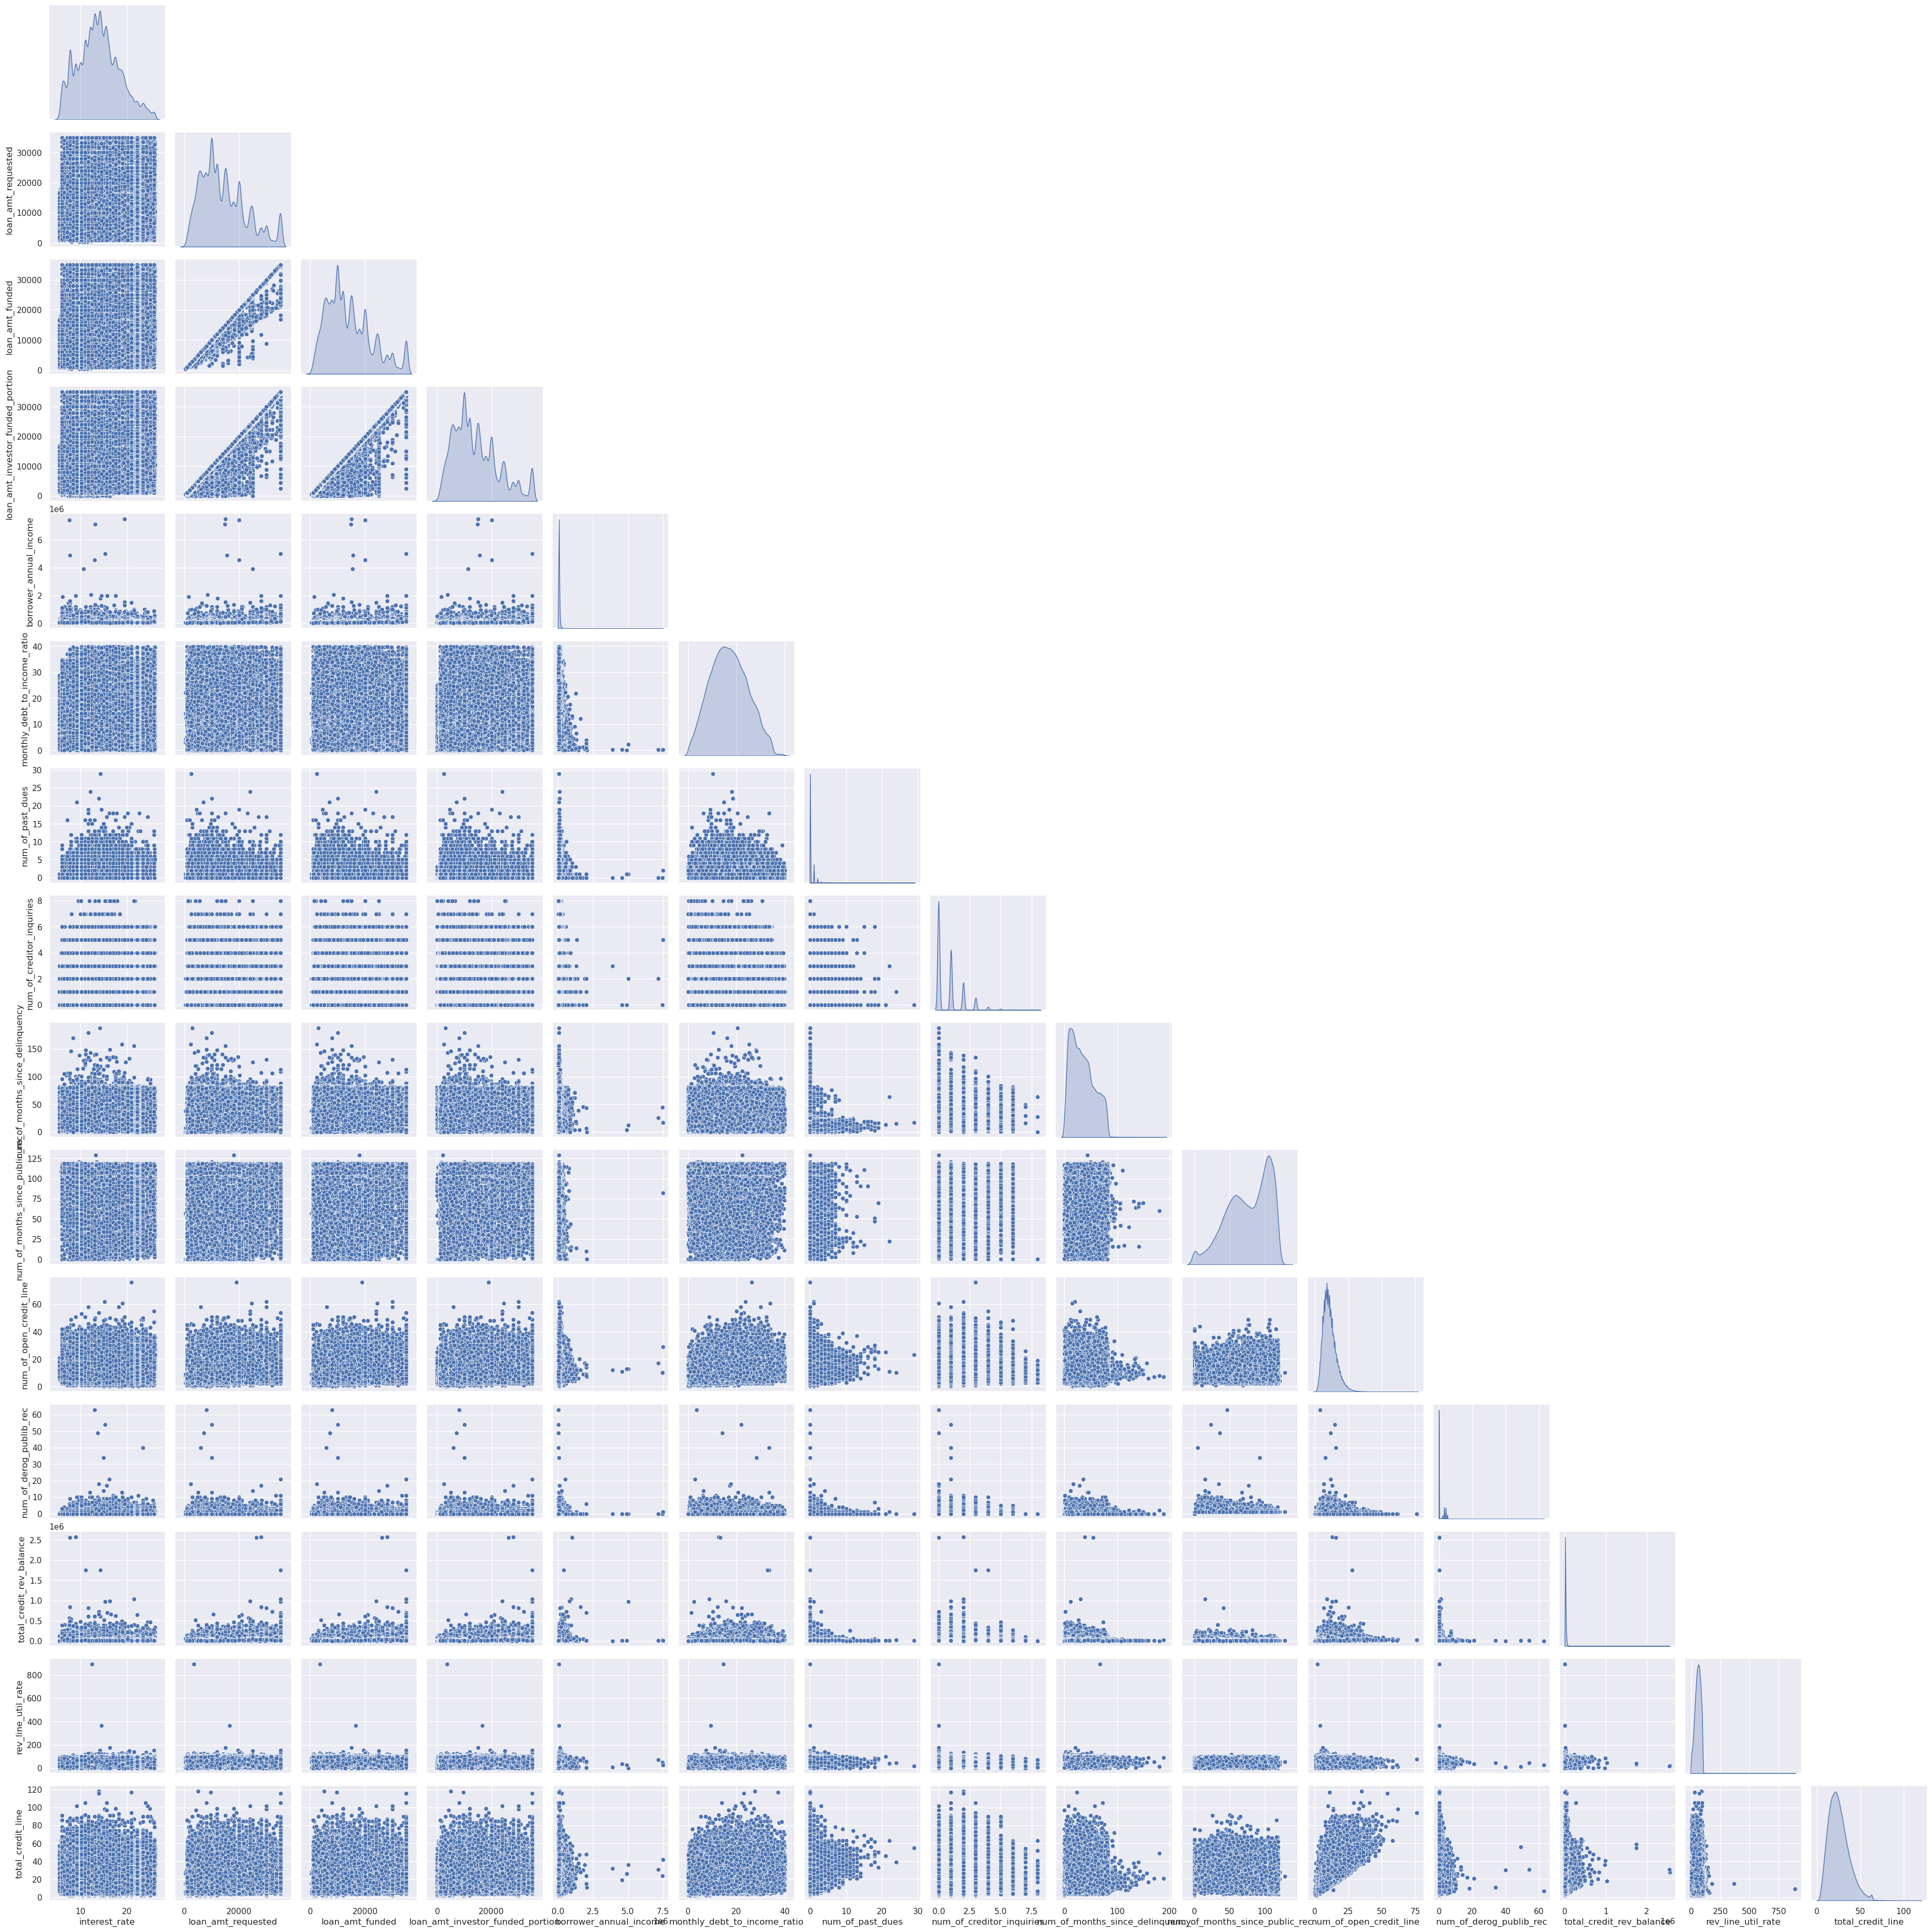

In [5]:
# Scatter plot of the numerical features seaborn with lower traingle
sns.pairplot(train[num_feat], diag_kind="kde", corner=True)
plt.show();

The following things are important to note:

* The three features `loan_amt_funded`, `loan_amt_requested`, `loan_amt_investor_funded_portion` are very similar. In fact, the first two only have different values in 1650 samples. Furthermore, `loan_amt_investor_funded_portion` and the other two features have about ~ 55000 different values. We will choose `loan_amt_requested` over `loan_amt_funded` since it is more likely we would observe the requested amount in practice. We can quantify these relationships as follows:

In [6]:
for method in ["pearson", "spearman", "kendall"]:
    train[["loan_amt_funded", "interest_rate"]].corr(
        method=method
    ).style.background_gradient(cmap="coolwarm")

In [7]:
for method in ["pearson", "spearman", "kendall"]:
    train[["loan_amt_requested", "interest_rate"]].corr(
        method=method
    ).style.background_gradient(cmap="coolwarm")

* The following features have skewed distributions. While we will primarily use tree-based models, it may still be useful to transform these features to normalize them. For instance, in each boosting rounds, the trees would be trained on a sample of all training examples via the `subsample` parameter (xgboost). And so a distribution of the data that is more normal will give each sample more of a chance of being selected for training:

    - `borrower_annual_income`
    - `num_past_dues`
    - `total_credit_rev_balance`
    - `rev_line_util_rate`


## Missingness

In [8]:
((train.isna().sum(axis=0) / len(train)) * 100).round(4)

interest_rate                          0.0000
id_loan                                0.0000
id_borrower                            0.0000
loan_amt_requested                     0.0000
loan_amt_funded                        0.0000
loan_amt_investor_funded_portion       0.0000
num_of_payment_months                  0.0000
loan_grade                            15.3002
loan_subgrade                         15.3002
self_filled_employer_job_title         6.1961
num_of_years_employed                  4.3642
home_ownership_status                 15.3277
borrower_annual_income                15.2663
verify_income_or_source                0.0000
loan_issued_date                       0.0000
borrower_provided_reason_for_loan     69.0659
borrower_provided_loan_category        0.0000
borrower_provided_loan_title           3.1352
zip_first_three                        0.0000
borrower_state                         0.0000
monthly_debt_to_income_ratio           0.0000
num_of_past_dues                  

<AxesSubplot: >

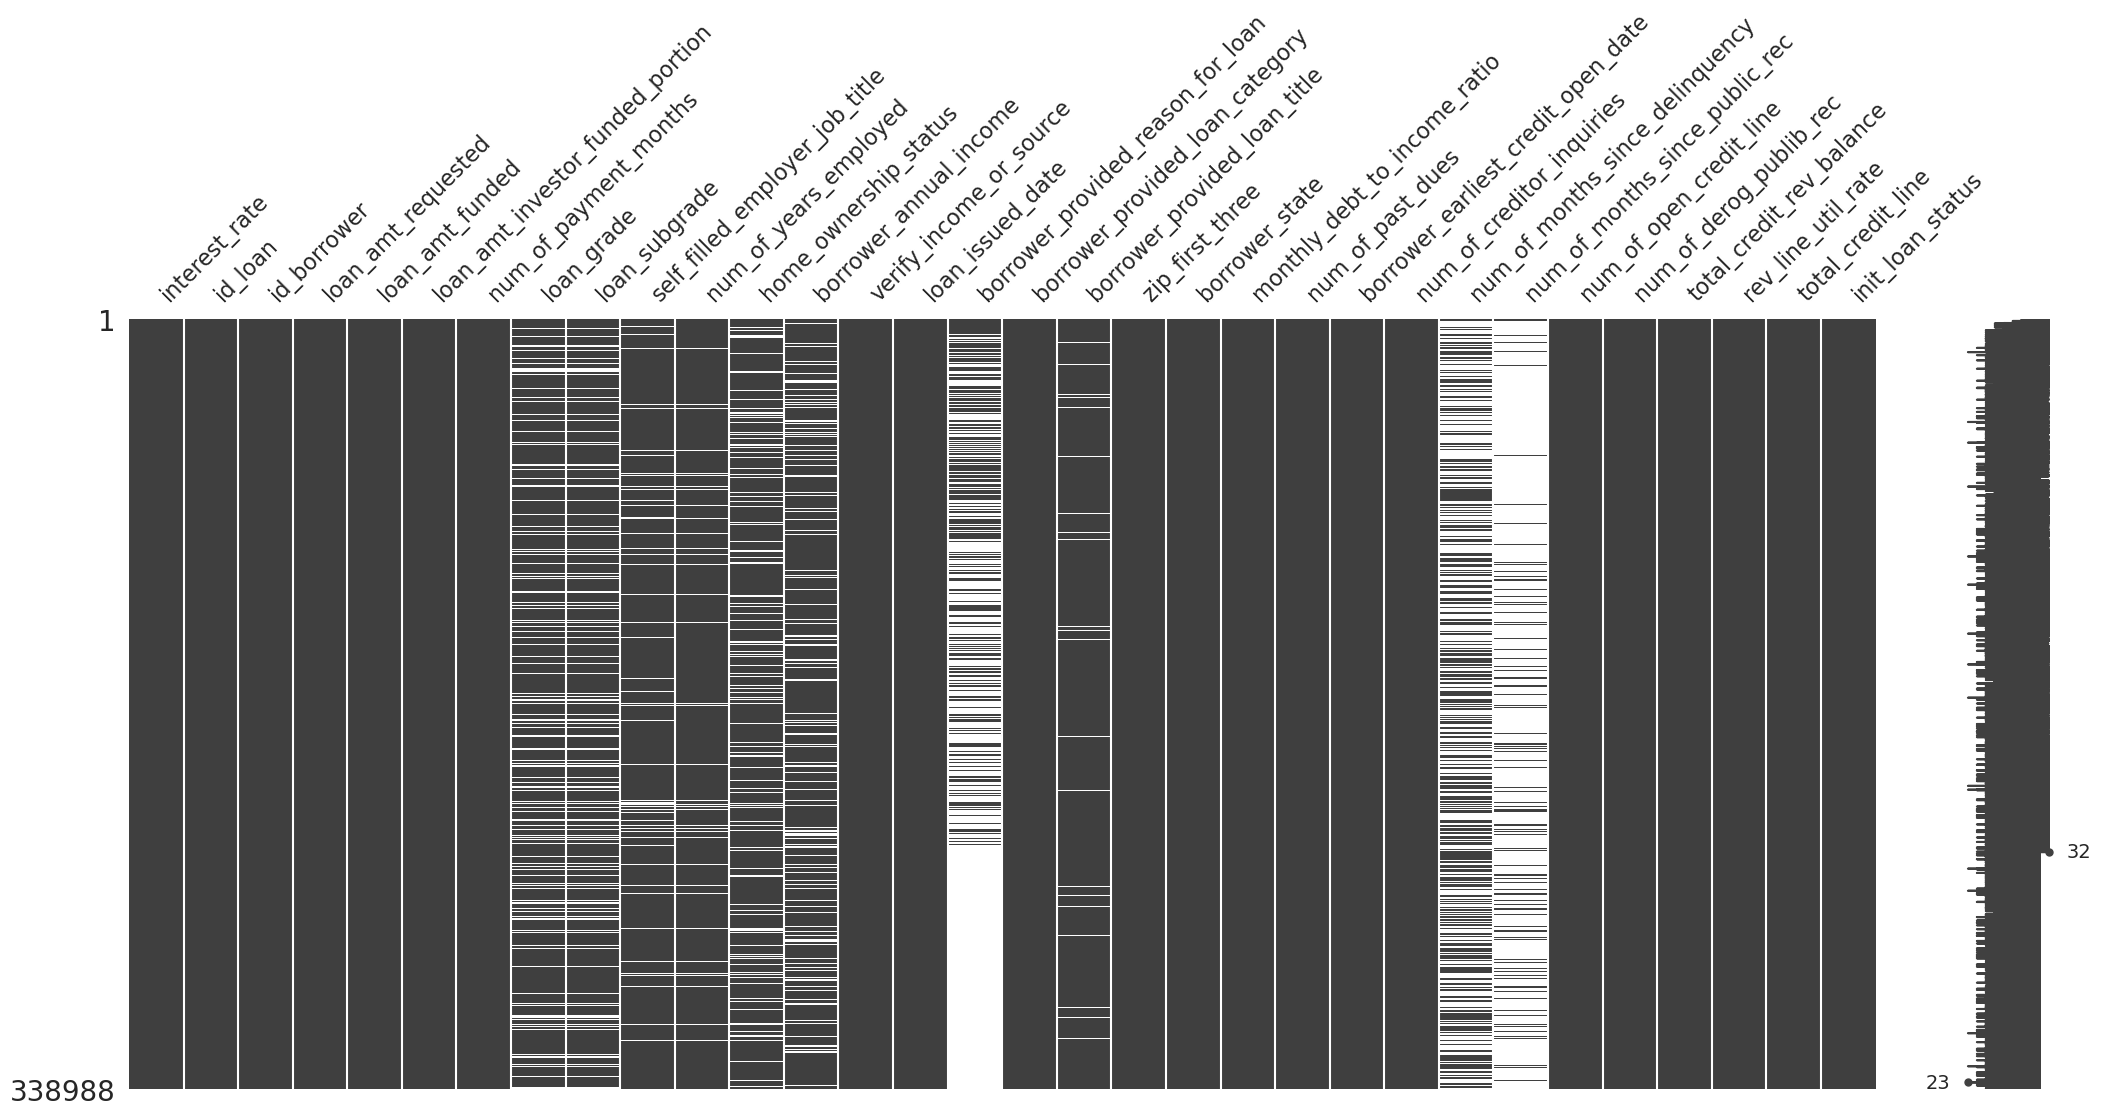

In [9]:
matrix(train)

As can be seen, the following features appear to be missing at random:

* loan_grade

* loan_subgrade

* self_filled_employer_job_title

* num_of_years_employed

* home_ownership_status

* borrower_annual_income

* rev_line_util_rate 

The following features are missing in more than 50 percent of its values:

* borrower_provided_reason_for_loan (> 69%)

* num_of_months_since_delinquency (> 54%)

* num_of_months_since_public_rec (> 87%)

At this point, even imputation may not be able to recover any signal or information that would have been contained in these features. Without multiple imputation, we would not be able to ascertain more sufficiently whether imputation of these high nullity features would improve our results or add noise. What is more, the feature `borrower_provided_reason_for_loan` does not appear to be missing at random, and so we would usually investigate this by going to the data source. Fortunately, the other two features `borrower_provided_loan_category` and `borrower_provided_loan_title` may be able replace this high nullity feature since they may contain similar information. Below, we conduct chi-squared tests of independence for the combinations of these features.

In [10]:
for combs in combinations(
    [
        "borrower_provided_loan_category",
        "borrower_provided_loan_title",
        "borrower_provided_reason_for_loan",
    ],
    2,
):
    if (
        "borrower_provided_loan_title" in combs
        and "borrower_provided_reason_for_loan" in combs
    ):
        continue
    else:
        result = (
            chi2_contingency(
                pd.crosstab(index=train[combs[0]], columns=train[combs[0]])
            )[1]
            < 0.01
        )
        if result:
            print("Reject null: the combinations ", combs, " are correlated")
        else:
            print(
                "Fail to reject null: the combinations ", combs, " are not correlated"
            )

Reject null: the combinations  ('borrower_provided_loan_category', 'borrower_provided_loan_title')  are correlated
Reject null: the combinations  ('borrower_provided_loan_category', 'borrower_provided_reason_for_loan')  are correlated


We will drop the `borrower_provided_loan_title` and `borrower_provided_reason_for_loan` features and simply use the `borrower_provided_loan_category` feature on the grounds of the statistical tests. We can also examine the nullity heatmap:

<AxesSubplot: >

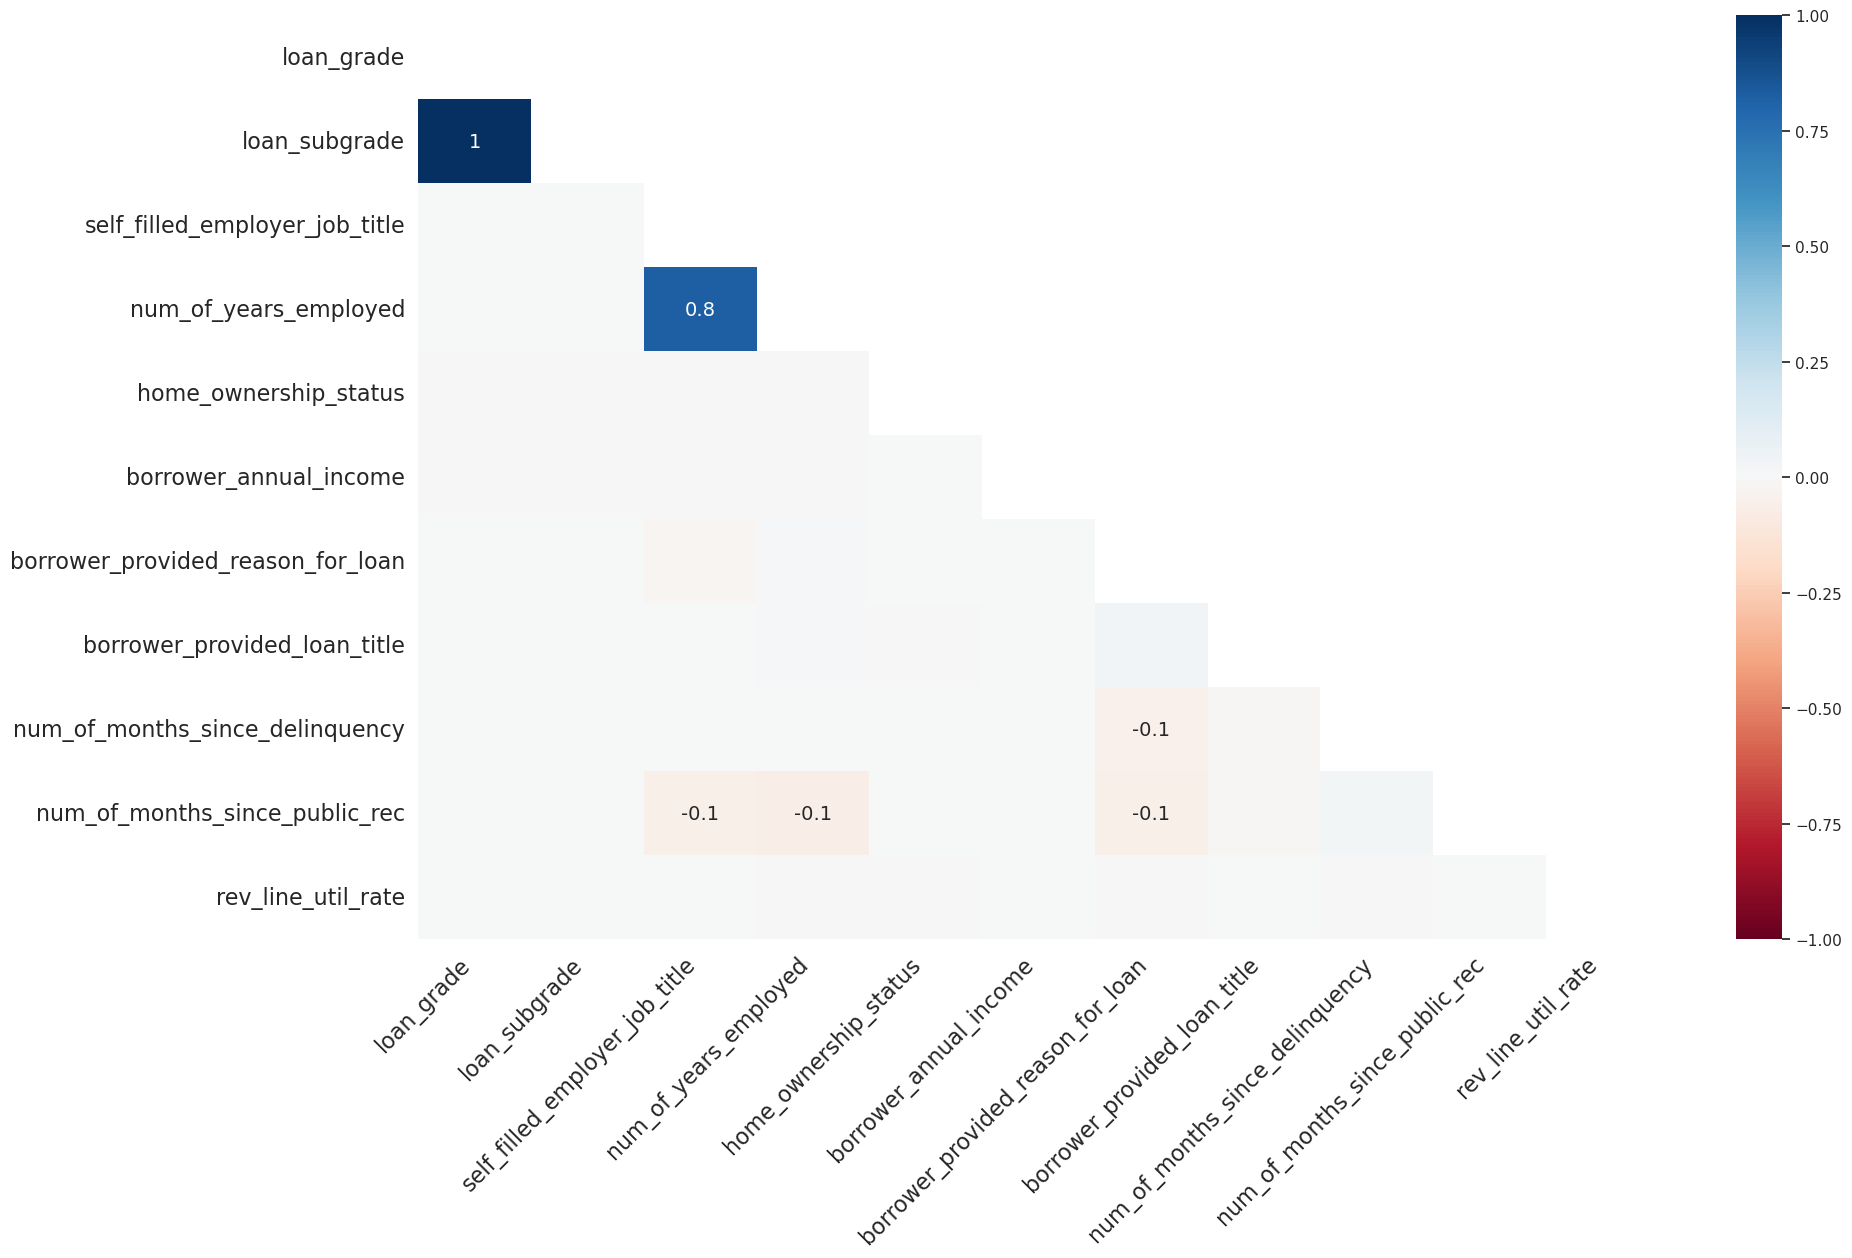

In [11]:
heatmap(train)

The grades and the employment features are correlated as expected. As for the `num_of_months_since_delinquency`, we can check its correlation with the target as follows:

In [12]:
train[["num_of_months_since_delinquency", "interest_rate"]].corr(
    method="spearman"
).style.background_gradient(cmap="coolwarm")

In [13]:
train[["num_of_months_since_delinquency", "interest_rate"]].corr(
    method="kendall"
).style.background_gradient(cmap="coolwarm")

In [14]:
train[["num_of_months_since_delinquency", "interest_rate"]].corr(
    method="pearson"
).style.background_gradient(cmap="coolwarm")

Is 'num_of_months_since_delinquency' potentially interacting with any other numerical features?

In [15]:
train.corrwith(train["num_of_months_since_delinquency"], method="kendall")

interest_rate                      -0.038507
id_loan                            -0.033292
id_borrower                        -0.032140
loan_amt_requested                 -0.027464
loan_amt_funded                    -0.027496
loan_amt_investor_funded_portion   -0.024449
borrower_annual_income             -0.061047
monthly_debt_to_income_ratio        0.003045
num_of_past_dues                   -0.658592
num_of_creditor_inquiries           0.009399
num_of_months_since_delinquency     1.000000
num_of_months_since_public_rec      0.002013
num_of_open_credit_line            -0.039054
num_of_derog_publib_rec             0.076420
total_credit_rev_balance           -0.008717
rev_line_util_rate                  0.019647
total_credit_line                  -0.046083
dtype: float64

In [16]:
train.corrwith(train["num_of_months_since_delinquency"], method="spearman")

interest_rate                      -0.056929
id_loan                            -0.049182
id_borrower                        -0.047493
loan_amt_requested                 -0.040513
loan_amt_funded                    -0.040560
loan_amt_investor_funded_portion   -0.036089
borrower_annual_income             -0.090474
monthly_debt_to_income_ratio        0.004567
num_of_past_dues                   -0.820158
num_of_creditor_inquiries           0.012271
num_of_months_since_delinquency     1.000000
num_of_months_since_public_rec     -0.007005
num_of_open_credit_line            -0.056448
num_of_derog_publib_rec             0.093842
total_credit_rev_balance           -0.013149
rev_line_util_rate                  0.029331
total_credit_line                  -0.067786
dtype: float64

In [17]:
train.corrwith(train["num_of_months_since_delinquency"], method="pearson")

interest_rate                      -0.058437
id_loan                            -0.039284
id_borrower                        -0.039137
loan_amt_requested                 -0.040290
loan_amt_funded                    -0.040420
loan_amt_investor_funded_portion   -0.036868
borrower_annual_income             -0.057584
monthly_debt_to_income_ratio        0.007907
num_of_past_dues                   -0.577097
num_of_creditor_inquiries           0.006944
num_of_months_since_delinquency     1.000000
num_of_months_since_public_rec      0.021145
num_of_open_credit_line            -0.047898
num_of_derog_publib_rec             0.082752
total_credit_rev_balance           -0.023510
rev_line_util_rate                  0.026663
total_credit_line                  -0.062171
dtype: float64

Indeed, the `num_of_months_since_delinquency` feature has a dependency with `num_of_past_dues` in both the original space (pearson) and an even stronger one in the transformed space (spearman). In other words, we hope that these two features contain similar signals such that one can be used instead of the other. However, it may also be the case that these two features are correlated but convey different signals--- `num_of_past_dues` provides information on a total number and `num_of_months_since_delinquency` gives the time elapsed since last delinquency, which tackles the applicant riskiness from different angles.  

### Missingness Conclusion

For EDA, we will drop `borrower_provided_reason_for_loan`, `borrower_provided_reason_for_loan`, `num_of_months_since_public_rec` and `num_of_months_since_delinquency` and impute the other missing columns. However, we will try to keep `num_of_months_since_delinquency` (missing ~ $54 \%$) for training. 

In [18]:
train.drop(
    [
        "num_of_months_since_public_rec",
        "borrower_provided_reason_for_loan",
        "num_of_months_since_delinquency",
        "borrower_provided_loan_title",
    ],
    axis=1,
    inplace=True,
)
train.shape

(338988, 28)

## Date Features

The date features deserve some attention since there are two sets of dates. It would be important to understand if there are patterns between the date features and the interest rates. First, we will extract the years and months into individual columns:

In [19]:
train[["loan_issued_year", "borrower_earliest_credit_open_year"]] = train[
    ["loan_issued_date", "borrower_earliest_credit_open_date"]
].apply(lambda col: pd.to_datetime(col).dt.to_period("M").dt.year)
train[["loan_issued_month", "borrower_earliest_credit_open_month"]] = train[
    ["loan_issued_date", "borrower_earliest_credit_open_date"]
].apply(lambda col: pd.to_datetime(col).dt.to_period("M").dt.month)
train.drop(
    ["loan_issued_date", "borrower_earliest_credit_open_date"], axis=1, inplace=True
)

date_cols = [
    col for col in train.columns if col.endswith("year") or col.endswith("month")
]
train[date_cols]

loan_issued_year  borrower_earliest_credit_open_year  \
0                   2009                                1994   
1                   2008                                2000   
2                   2014                                2000   
3                   2010                                1985   
4                   2009                                1996   
...                  ...                                 ...   
338983              2014                                2003   
338984              2014                                2007   
338985              2014                                2004   
338986              2014                                1994   
338987              2014                                2010   

        loan_issued_month  borrower_earliest_credit_open_month  
0                       8                                    2  
1                       5                                   10  
2                       8                                    6  
3                       3                                    1  
4                      11                                   12  
...                   ...                                  ...  
338983                 10                                   11  
338984                 10                                   10  
338985                 10                                   10  
338986                 10                                    3  
338987                 10                                    9  

[338988 rows x 4 columns]

* For `loan_issued_year` and `loan_issued_month`:

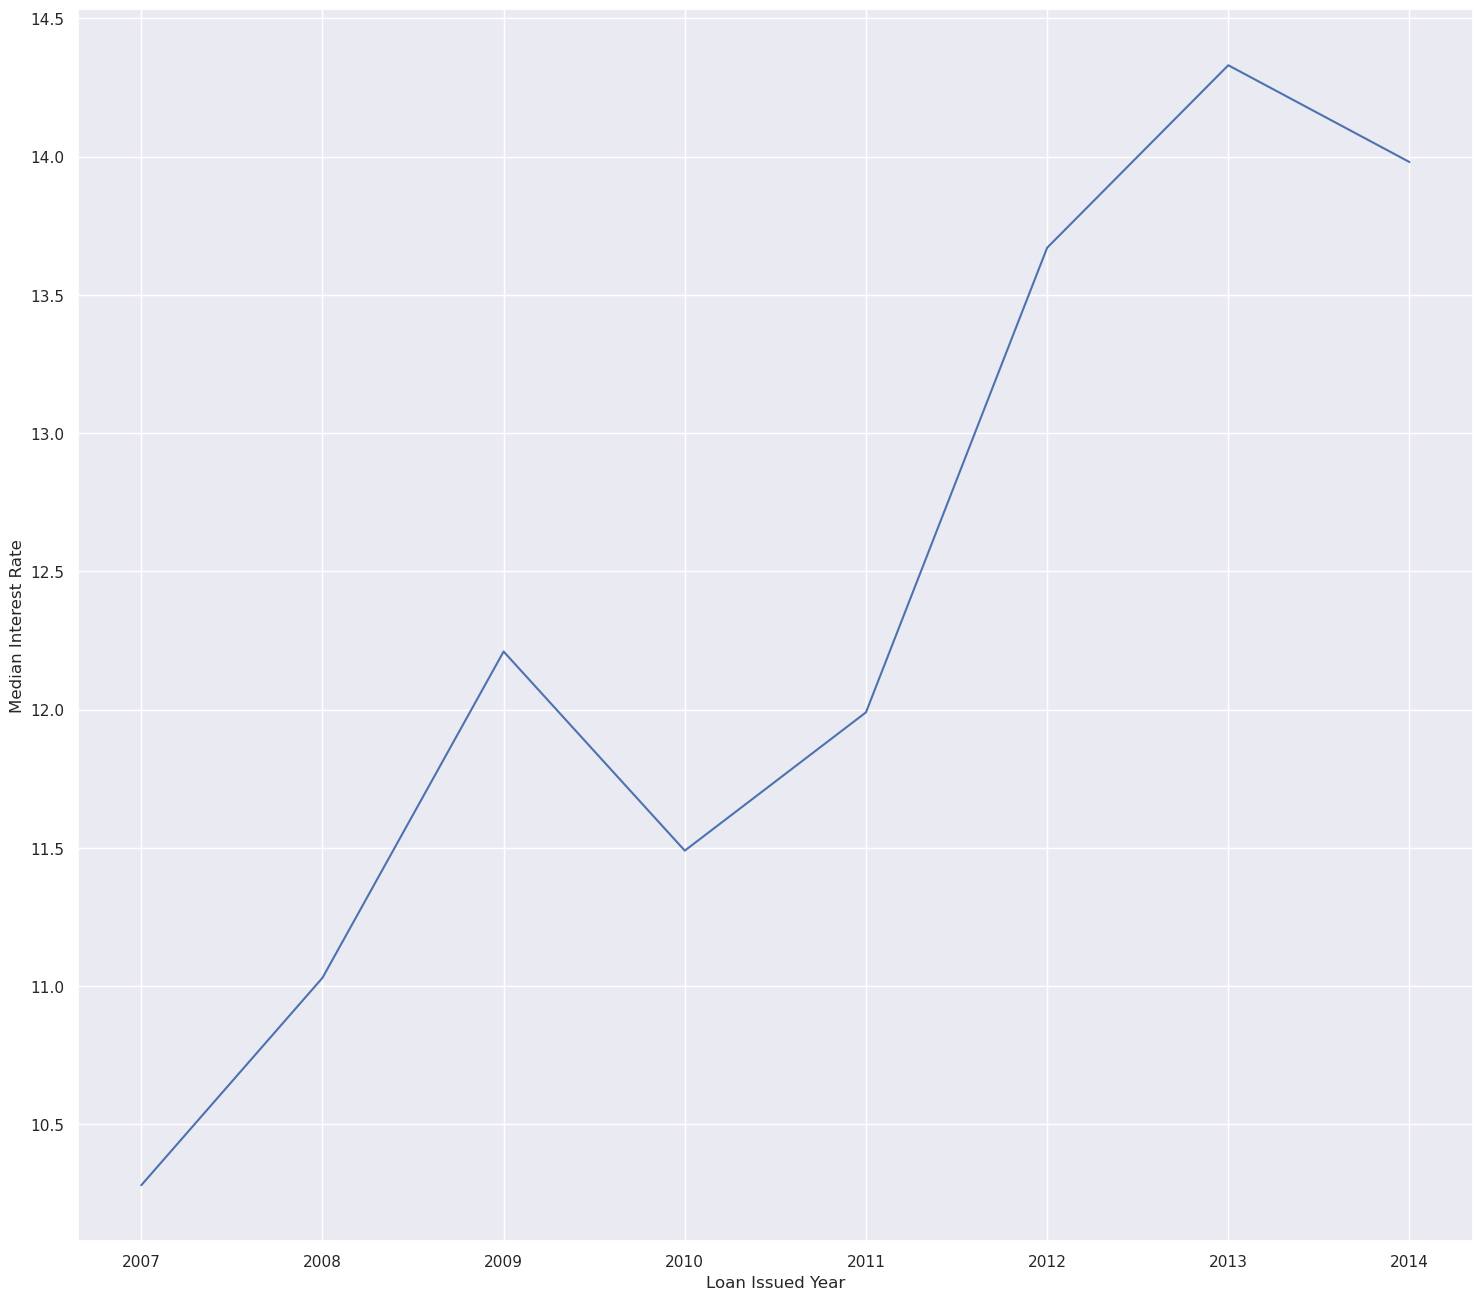

In [20]:
plt.plot(train.groupby("loan_issued_year")["interest_rate"].median(["interest_rate"]))
plt.xlabel("Loan Issued Year")
plt.ylabel("Median Interest Rate")
plt.show();

Median interest rates were higher following the 2008 financial crisis. If we use catboost encoding, this pattern will be captured by the newly encoded feature--- albeit the mean value will be used.


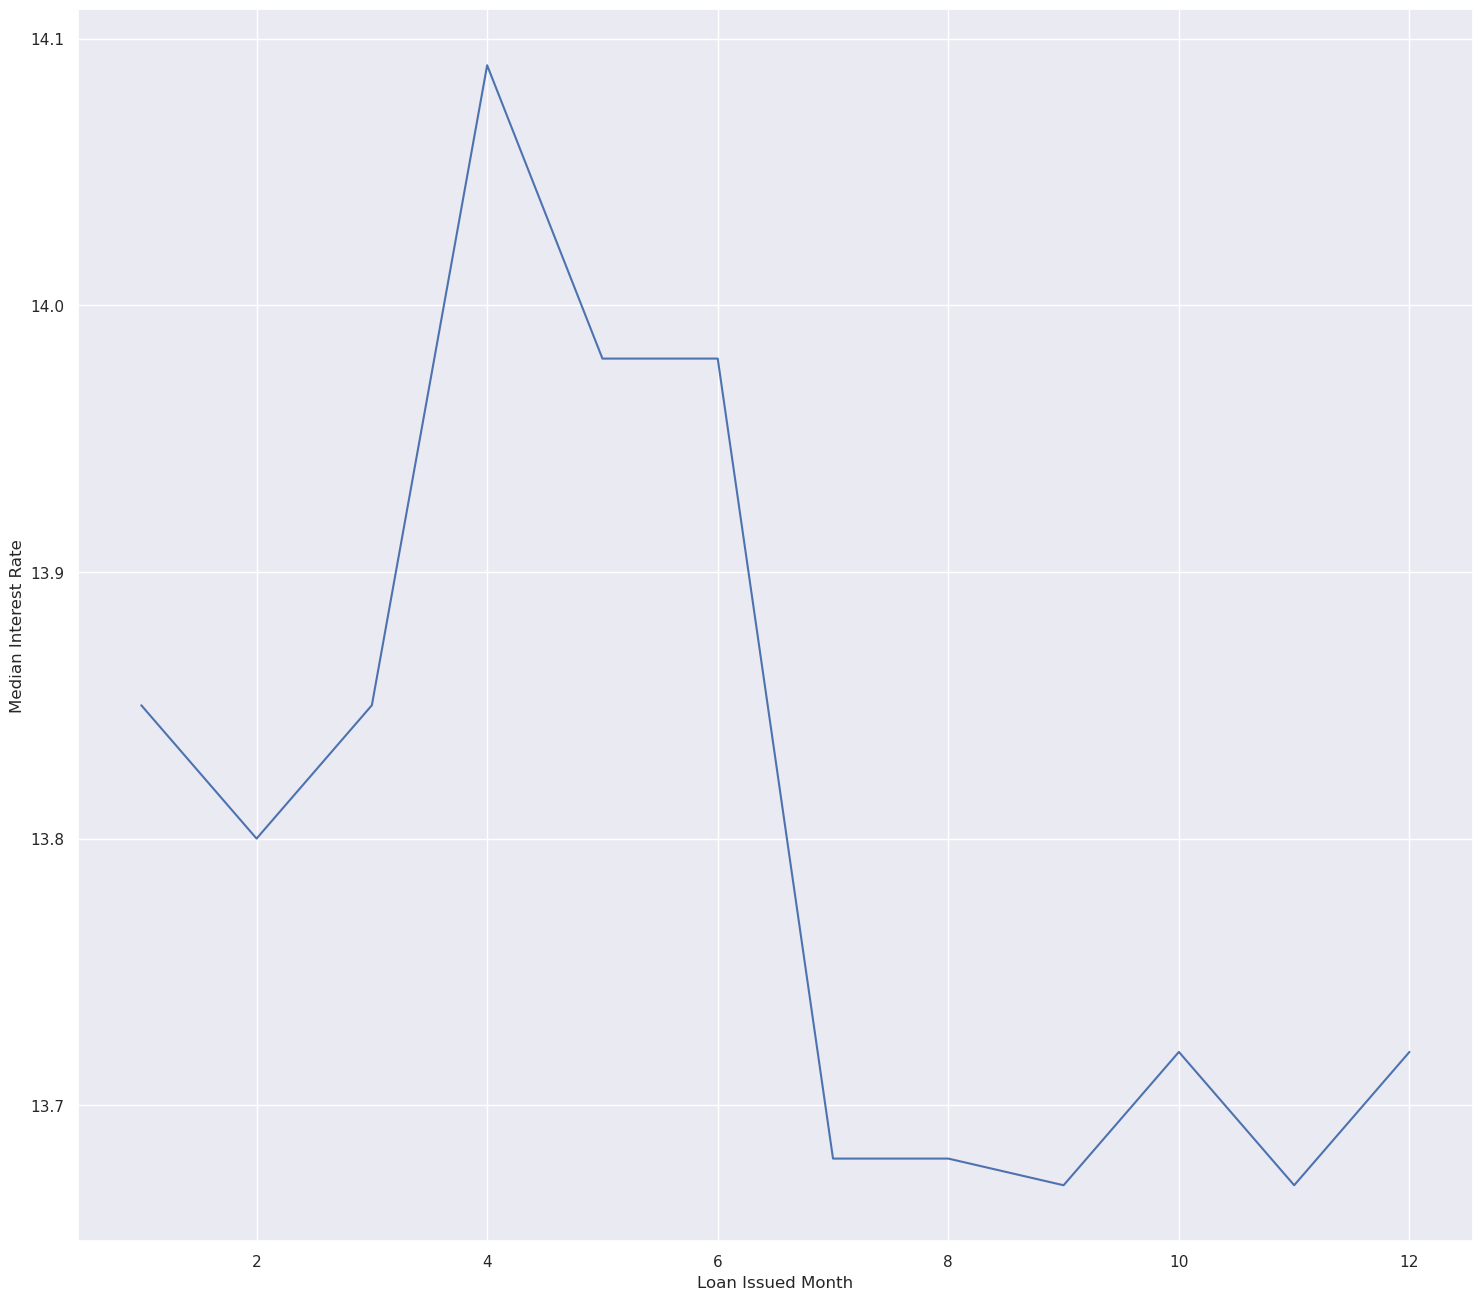

In [21]:
plt.plot(train.groupby("loan_issued_month")["interest_rate"].median(["interest_rate"]))
plt.xlabel("Loan Issued Month")
plt.ylabel("Median Interest Rate")
plt.show();

While there are certainly variations between median interest rates between the months in which the loans were issued, the y-axis range shows that these variations are not of great magnitudes. We will encode this features but it may be that our features selection algorithm will drop it due to low variance.

* For `borrower_earliest_credit_open_year` and `borrower_earliest_credit_open_month`:

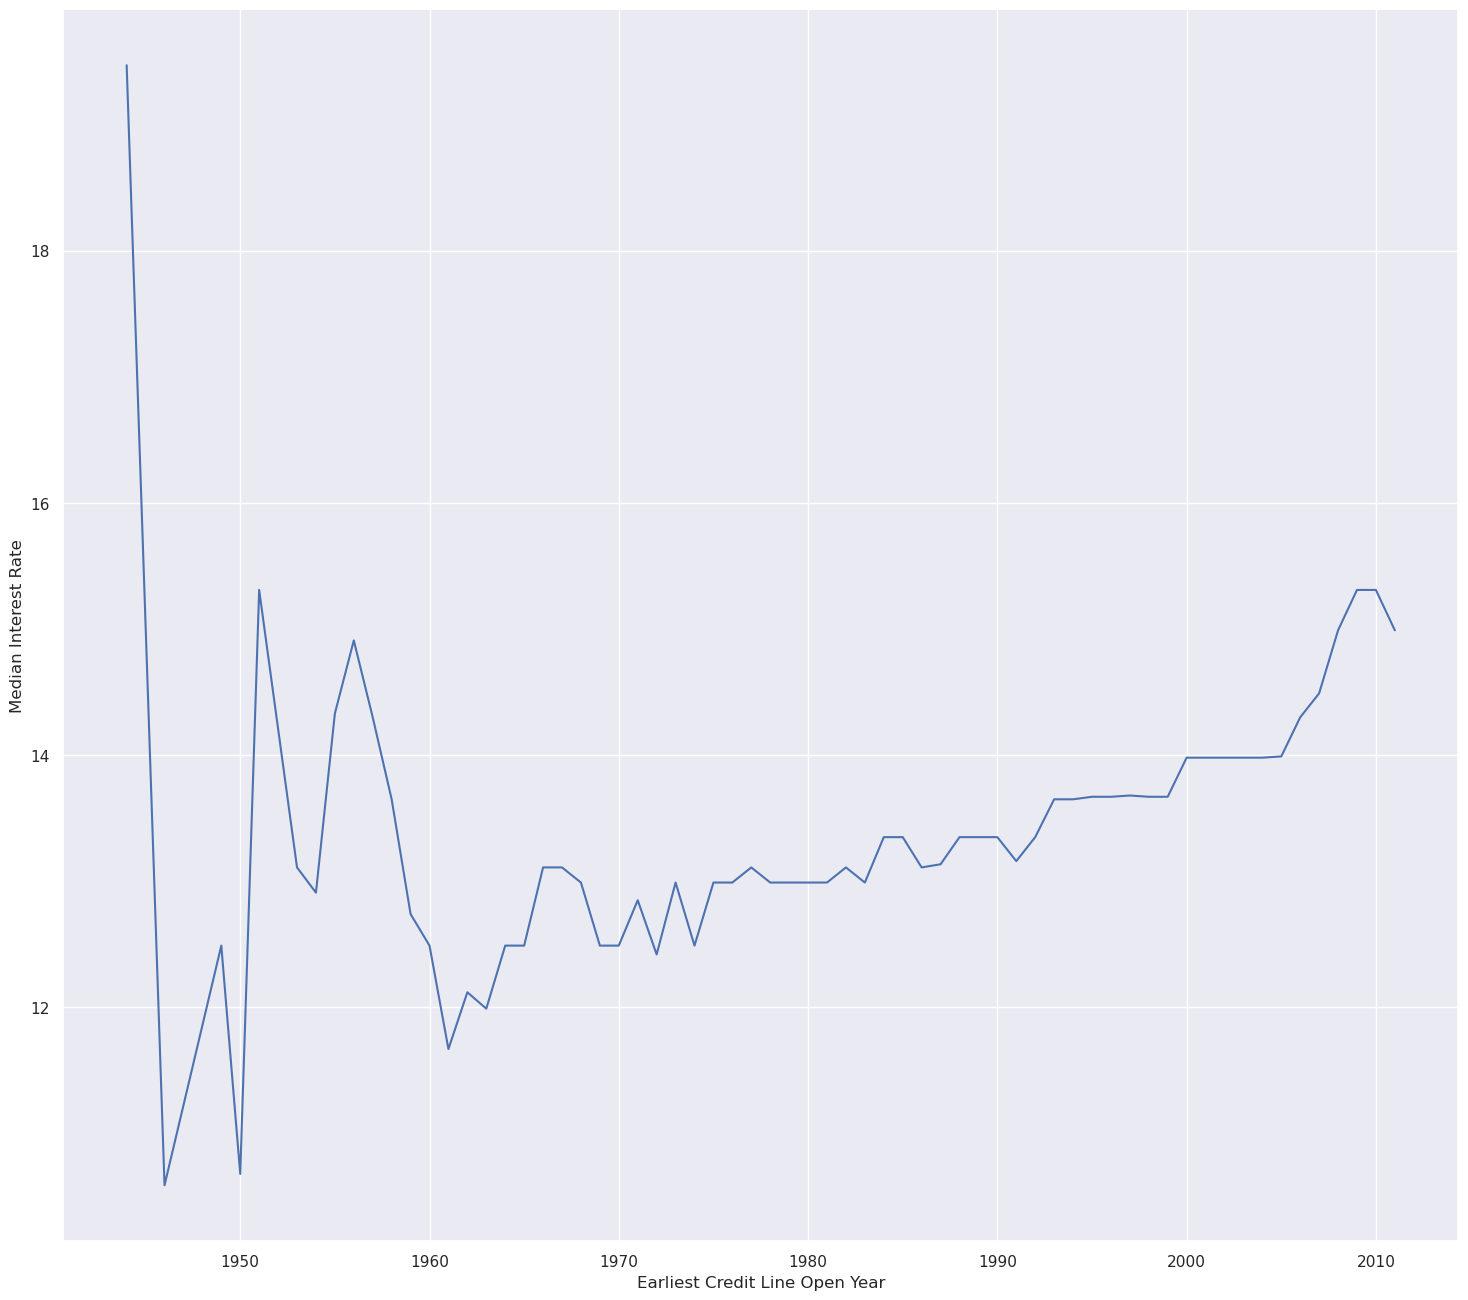

In [22]:
plt.plot(
    train.groupby("borrower_earliest_credit_open_year")["interest_rate"].median(
        ["interest_rate"]
    )
)
plt.xlabel("Earliest Credit Line Open Year")
plt.ylabel("Median Interest Rate")
plt.show();

Interestingly, median interest rates were very high for individuals whose earliest credit line open years were in the 40s and 50s. This may be due to the fact that people who opened their first credit lines back then are mostly phasing our of the work force, and so the lenders consider them as higher risk in terms of their earnings potential and abilities to pay back. This also explains why median interest rates are lowest for those whose earliest credit line open years were in the 80s and 90s (this age group may be the highest earning among all age groups and have the highest workforce participation rates); median interest rates are also higher for those whose earliest credit line open years were in the 2000s (i.e., younger workers).

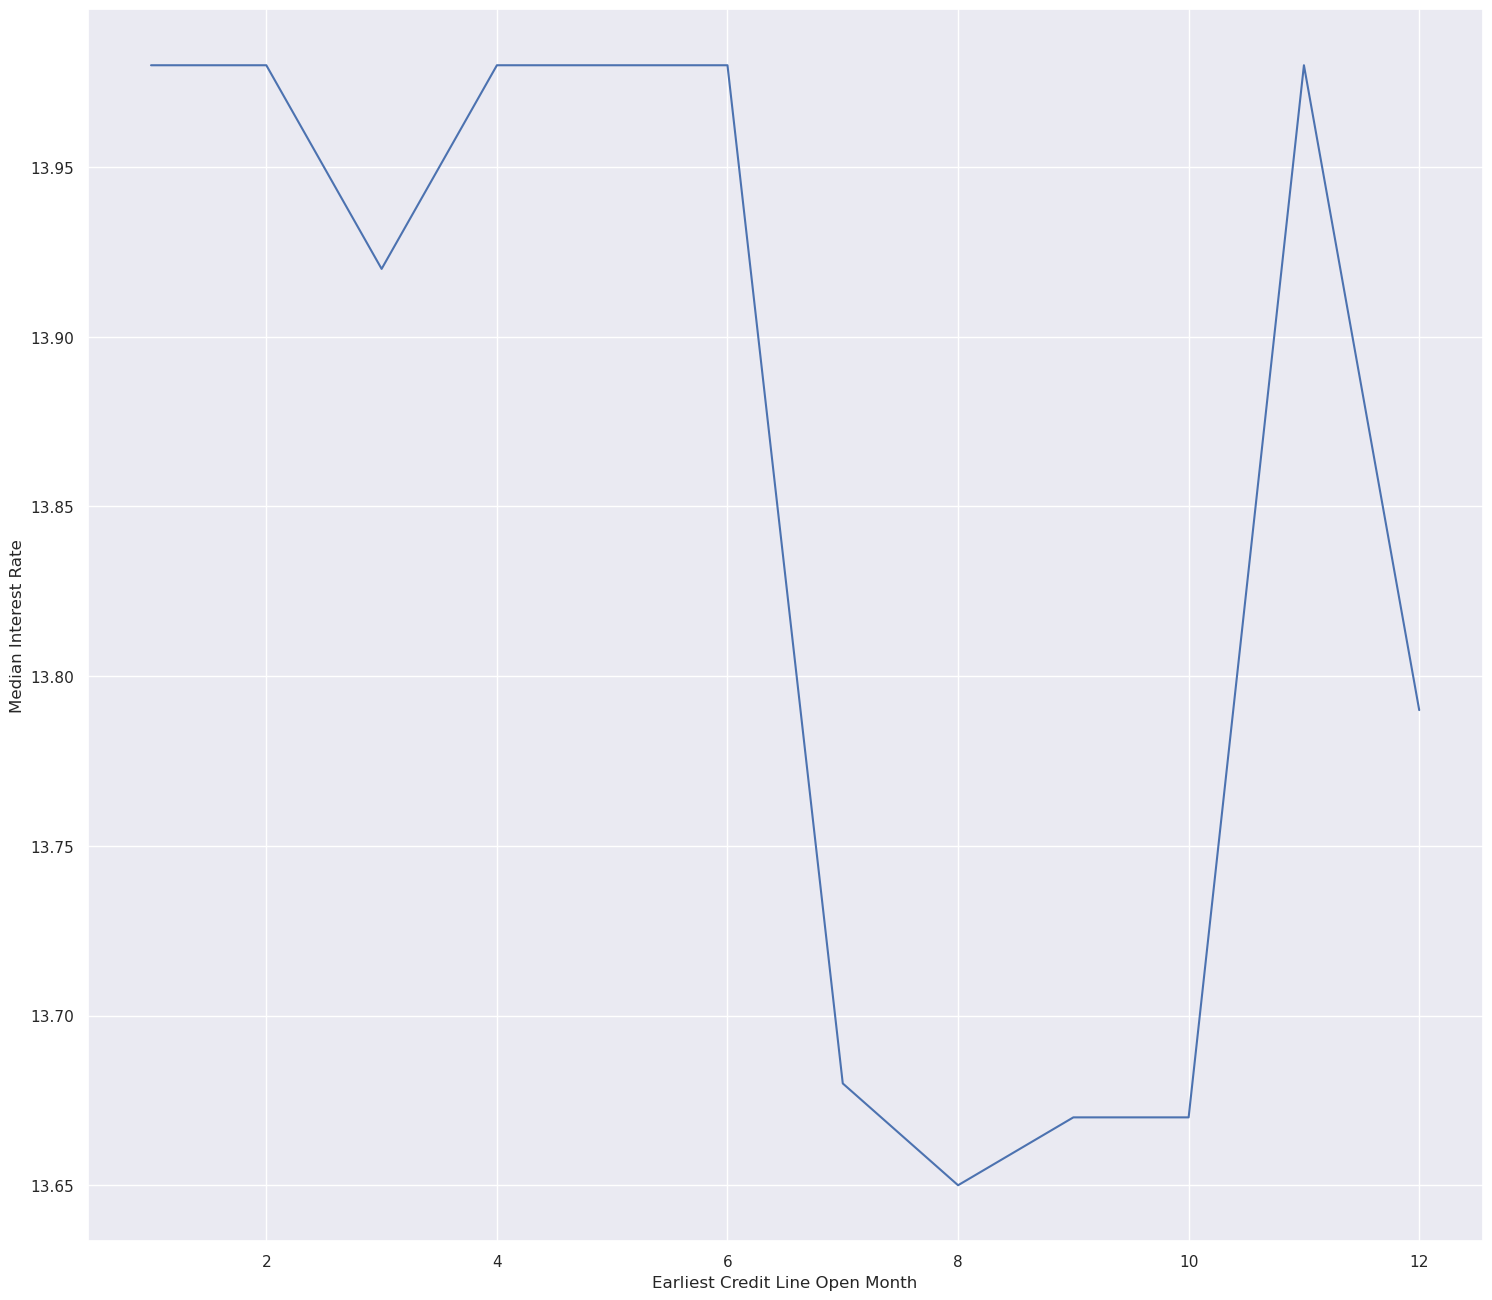

In [23]:
plt.plot(
    train.groupby("borrower_earliest_credit_open_month")["interest_rate"].median(
        ["interest_rate"]
    )
)
plt.xlabel("Earliest Credit Line Open Month")
plt.ylabel("Median Interest Rate")
plt.show();

Again, the variations between median interest rates by months are not as significant since they all are within 1 percentage point from each other.

### Date Features Conclusion

We will drop the month features and keep the year features for the EDA. We will, however, keep the months features at training time. We will just focus on using the year rather than the month features to generate new features.

In [24]:
train.drop([col for col in date_cols if col.endswith("month")], axis=1, inplace=True)
train.shape

(338988, 28)

In [25]:
train[[col for col in train.columns if col.endswith("year")]] = train[
    [col for col in train.columns if col.endswith("year")]
].astype("object")
train[[col for col in train.columns if col.endswith("year")]].dtypes

loan_issued_year                      object
borrower_earliest_credit_open_year    object
dtype: object

## Employer and Job Title

This feature has a large number of unique categories (high cardinality), and so we need to address this. Using a hashing vectorizer (`HashingVectorizer`) is an option for handling it but this may balloon the dimensionality. We might need to increase the number of output features to $2^{15}$ or $32,768$ in order to limit the number of hash collision given the $136,809$ unique categories in this feature. Instead, we will first explore using the K-Modes clustering algorithm to create a column of cluster labels to see if we can replace these job titles and employer names with the clustering output.   

In [26]:
len(train["self_filled_employer_job_title"].unique())

136809

Before any clustering, we might suspect that the employer and job titles feature is related to the grade and subgrade columns. In other words, do the grades and subgrades assigned by the lending club already encode information about the job titles and employers of the loan applicants? If so, then we can proceed with an understanding that, if the results of K-Modes and hashing vectorizers are not ideal, we can drop the this high cardinal feature and rely more on the grades features as measures of riskiness. 

In [27]:
for combs in combinations(
    ["loan_subgrade", "loan_grade", "self_filled_employer_job_title"], 2
):
    if "loan_subgrade" in combs and "loan_grade" in combs:
        continue
    else:
        result = (
            chi2_contingency(
                pd.crosstab(index=train[combs[0]], columns=train[combs[0]])
            )[1]
            < 0.01
        )
        if result:
            print("Reject null: the combinations ", combs, " are correlated")
        else:
            print(
                "Fail to reject null: the combinations ", combs, " are not correlated"
            )

Reject null: the combinations  ('loan_subgrade', 'self_filled_employer_job_title')  are correlated
Reject null: the combinations  ('loan_grade', 'self_filled_employer_job_title')  are correlated


This is important as the chi-squared tests of independence are rejected, meaning that the grade features are more likely to have incorporated information about the applicants' job titles and employers. However, to be more thorough, we will proceed with K-Modes and feature hashing to see if we can keep this feature if possible. First, we need to impute the missing values with a constant value 'missing':

In [28]:
emp_feature = pd.DataFrame(
    {
        "job_or_employer": SimpleImputer(strategy="constant", fill_value="missing")
        .fit_transform(
            train["self_filled_employer_job_title"].values.reshape((len(train), 1))
        )
        .ravel()
    }
)
emp_feature

job_or_employer
0                                missing
1                                    cnn
2                         web programmer
3                    city beaumont texas
4                   state farm insurance
...                                  ...
338983          administrative assistant
338984                            helper
338985            facility administrator
338986  senior creative designerad sales
338987                       electrician

[338988 rows x 1 columns]

Next, we apply the K-Modes algorithm using the imputed dataframe above. We will try different number of clusters and check which number lowers the cost measure the most: 

In [29]:
costs = []
for n_clusters in range(3, 10):
    kmodes = KModes(n_clusters=n_clusters, init="Huang", n_init=5, n_jobs=-1)
    kmodes.fit(emp_feature)
    costs.append(kmodes.cost_)

KModes(init='Huang', n_clusters=3, n_init=5, n_jobs=-1)

KModes(init='Huang', n_clusters=4, n_init=5, n_jobs=-1)

KModes(init='Huang', n_clusters=5, n_init=5, n_jobs=-1)

KModes(init='Huang', n_clusters=6, n_init=5, n_jobs=-1)

KModes(init='Huang', n_clusters=7, n_init=5, n_jobs=-1)

KModes(init='Huang', n_init=5, n_jobs=-1)

KModes(init='Huang', n_clusters=9, n_init=5, n_jobs=-1)

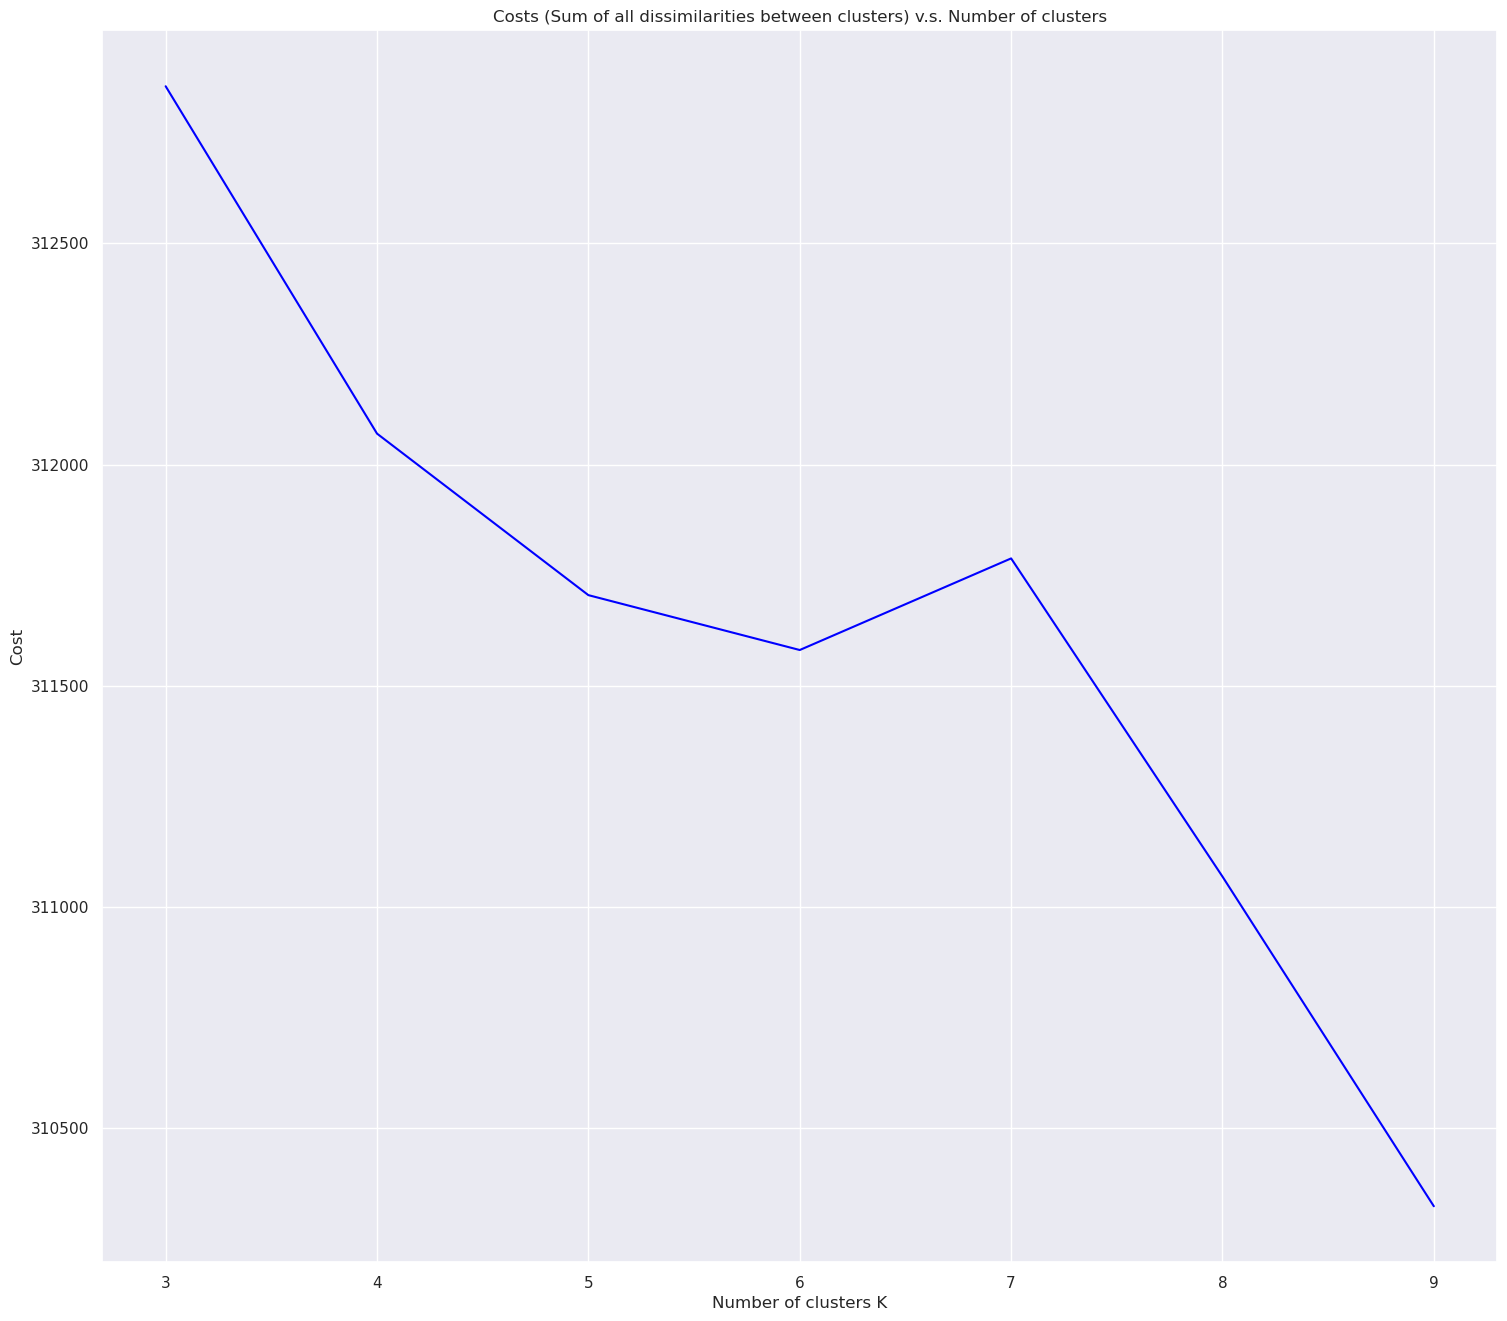

In [30]:
plt.plot(range(3, 10), costs, color="blue")
plt.title("Costs (Sum of all dissimilarities between clusters) v.s. Number of clusters")
plt.xticks(range(3, 10))
plt.xlabel("Number of clusters K")
plt.ylabel("Cost");

The function is non-convex (i.e., it has a concave portion for clusters 3 to 5) but it is decreasing, and so we have to rely on heuristics. Based on these values of costs, we will select 6 as the number of clusters.

In [31]:
kmodes = KModes(n_clusters=6, init="Huang", n_init=10, n_jobs=-1)
train["job_emp_clusters"] = kmodes.fit_predict(emp_feature)

To visualize the results of our clustering in high dimensional space, we will use the FAMD technique to reduce the dimensionality of our data matrix.

## Factor Analysis of Mixed Data

Since we have mixed data (cateogrical and continous), we will combine PCA (continous) and Multiple factor analysis (categorical) to reduce the dimensionality of the data matrix. We start with a pipeline that does the following:

* Standardize the numerical features

* Impute missing values for both numerical and categorical features:
  
  * Mean imputation for numerical
  * Constant value imputation for categorical

In [32]:
# Remove cluster labels, target, and id columns
cluster_data = train.drop(
    [
        "interest_rate",
        "id_loan",
        "id_borrower",
        "job_emp_clusters",
        "self_filled_employer_job_title",
    ],
    axis=1,
)
cluster_data.shape

(338988, 24)

In [33]:
# Numerical features
num_cols = cluster_data.select_dtypes("number").columns.to_list()
# Categorical features
cat_cols = cluster_data.select_dtypes("object").columns.to_list()

In [34]:
# Pipeline
famd_pipeline = Pipeline(
    [
        (
            "scaler",
            ColumnTransformer(
                [("", StandardScaler(), num_cols)], remainder="passthrough"
            ),
        ),
        (
            "num_imputer",
            ColumnTransformer(
                [
                    (
                        "",
                        SimpleImputer(),
                        ["__rev_line_util_rate", "__borrower_annual_income"],
                    )
                ],
                remainder="passthrough",
            ),
        ),
        (
            "cat_imputer",
            ColumnTransformer(
                [
                    (
                        "",
                        SimpleImputer(strategy="constant", fill_value="missing"),
                        [
                            "remainder__remainder__loan_grade",
                            "remainder__remainder__loan_subgrade",
                            "remainder__remainder__num_of_years_employed",
                            "remainder__remainder__home_ownership_status",
                        ],
                    )
                ],
                remainder="passthrough",
            ),
        ),
    ]
)
famd_pipeline.set_output(transform="pandas")

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('', StandardScaler(),
                                                  ['loan_amt_requested',
                                                   'loan_amt_funded',
                                                   'loan_amt_investor_funded_portion',
                                                   'borrower_annual_income',
                                                   'monthly_debt_to_income_ratio',
                                                   'num_of_past_dues',
                                                   'num_of_creditor_inquiries',
                                                   'num_of_open_credit_line',
                                                   'num_of_derog_publib_rec',
                                                   'total_credit_rev...
                                                  ['__rev_line_util_rate',
                                                   '__borrower_annual_income'])])),
                ('cat_imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant'),
                                                  ['remainder__remainder__loan_grade',
                                                   'remainder__remainder__loan_subgrade',
                                                   'remainder__remainder__num_of_years_employed',
                                                   'remainder__remainder__home_ownership_status'])]))])

In [35]:
famd = FAMD(n_components=2, n_iter=5, engine="auto", random_state=rs)

cluster_data_transformed = famd_pipeline.fit_transform(cluster_data)

famd.fit(cluster_data_transformed)

FAMD(n_iter=5, random_state=RandomState(MT19937) at 0x7F8A2064A240)

Next, we attach the cluster labels to the transformed components:

In [36]:
pcs = famd.transform(cluster_data_transformed)

pcs["labels"] = train["job_emp_clusters"]

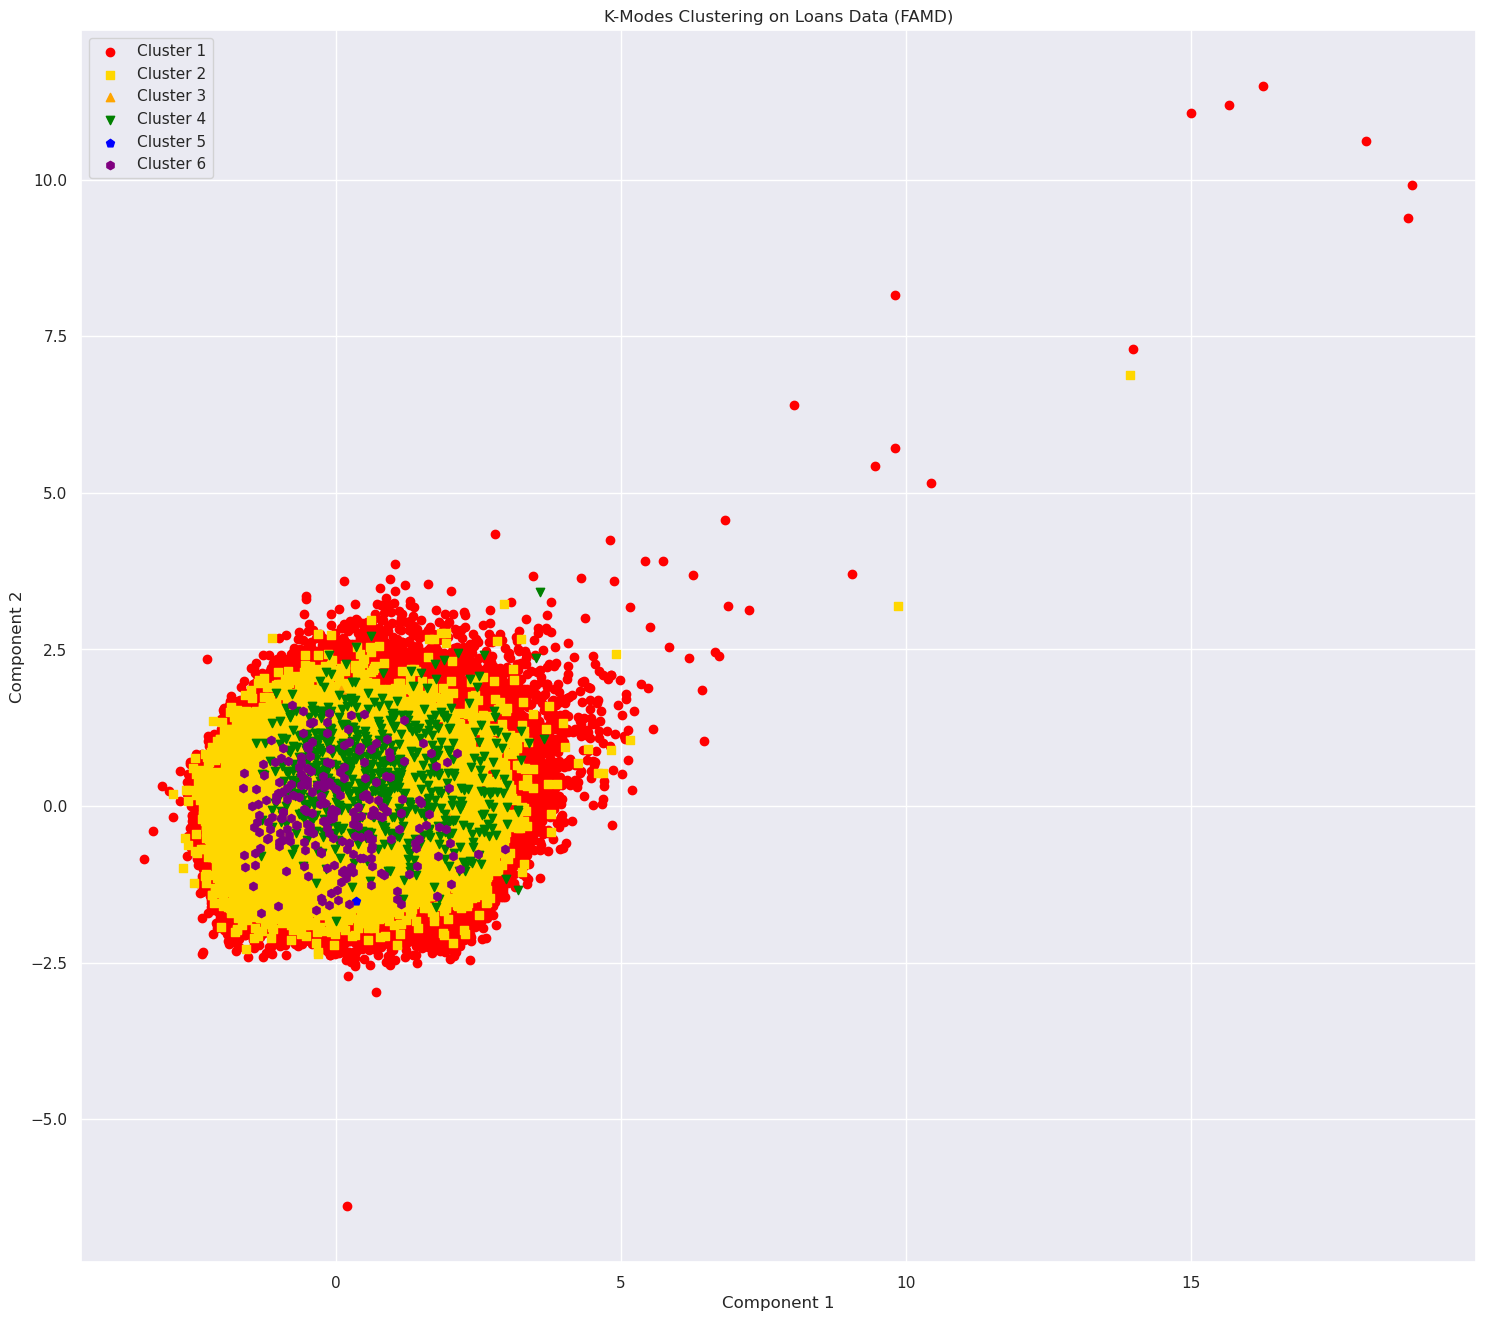

In [38]:
# Define a color map and markers for each cluster
colors = ["red", "gold", "orange", "green", "blue", "purple"]
markers = ["o", "s", "^", "v", "p", "h"]

# Create the scatter plot
fig, ax = plt.subplots()
for c in np.unique(pcs["labels"]):
    mask = pcs["labels"] == c
    ax.scatter(pcs[0][mask], pcs[1][mask], c=colors[c], marker=markers[c])

# Add axis labels and show the plot
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("K-Modes Clustering on Loans Data (FAMD)")
plt.legend(["Cluster" + f" {i + 1}" for i in range(18)])
plt.show();

The plot is not visually informative; this is likely because the first two principal components have relatively low explained inertia:

In [39]:
famd.explained_inertia_

array([0.00586633, 0.00274424])

This also informs us that the data matrix may not be intrinsically lower-dimensional. 

## T-SNE

We will try T-SNE for visualization. To do so, we have to encode the categorical variables using ordinal encoding. Similarly, we build a pipeline to carry out the steps: 

In [40]:
tsne_pipeline = Pipeline(
    [
        (
            "scaler",
            ColumnTransformer(
                [("", StandardScaler(), num_cols)], remainder="passthrough"
            ),
        ),
        (
            "num_imputer",
            ColumnTransformer(
                [
                    (
                        "",
                        SimpleImputer(),
                        ["__rev_line_util_rate", "__borrower_annual_income"],
                    )
                ],
                remainder="passthrough",
            ),
        ),
        (
            "cat_imputer",
            ColumnTransformer(
                [
                    (
                        "",
                        SimpleImputer(strategy="constant", fill_value="missing"),
                        [
                            "remainder__remainder__loan_grade",
                            "remainder__remainder__loan_subgrade",
                            "remainder__remainder__num_of_years_employed",
                            "remainder__remainder__home_ownership_status",
                        ],
                    )
                ],
                remainder="passthrough",
            ),
        ),
        (
            "cat_encode",
            ColumnTransformer(
                [
                    (
                        "",
                        OrdinalEncoder(),
                        [
                            "__remainder__remainder__loan_grade",
                            "__remainder__remainder__loan_subgrade",
                            "__remainder__remainder__num_of_years_employed",
                            "__remainder__remainder__home_ownership_status",
                            "remainder__remainder__remainder__borrower_earliest_credit_open_year",
                            "remainder__remainder__remainder__loan_issued_year",
                            "remainder__remainder__remainder__init_loan_status",
                            "remainder__remainder__remainder__borrower_state",
                            "remainder__remainder__remainder__zip_first_three",
                            "remainder__remainder__remainder__borrower_provided_loan_category",
                            "remainder__remainder__remainder__verify_income_or_source",
                            "remainder__remainder__remainder__num_of_payment_months",
                        ],
                    )
                ],
                remainder="passthrough",
            ),
        ),
    ]
)
tsne_pipeline.set_output(transform="pandas")

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('', StandardScaler(),
                                                  ['loan_amt_requested',
                                                   'loan_amt_funded',
                                                   'loan_amt_investor_funded_portion',
                                                   'borrower_annual_income',
                                                   'monthly_debt_to_income_ratio',
                                                   'num_of_past_dues',
                                                   'num_of_creditor_inquiries',
                                                   'num_of_open_credit_line',
                                                   'num_of_derog_publib_rec',
                                                   'total_credit_rev...
                                                   'remainder__remainder__remainder__loan_issued_year',
                                                   'remainder__remainder__remainder__init_loan_status',
                                                   'remainder__remainder__remainder__borrower_state',
                                                   'remainder__remainder__remainder__zip_first_three',
                                                   'remainder__remainder__remainder__borrower_provided_loan_category',
                                                   'remainder__remainder__remainder__verify_income_or_source',
                                                   'remainder__remainder__remainder__num_of_payment_months'])]))])

In [41]:
cluster_data_transformed = tsne_pipeline.fit_transform(cluster_data)

We will try various values of perplexity and learning rate:

In [42]:
tsne = TSNE(
    n_components=2,
    perplexity=50.0,
    learning_rate=100,
    n_neighbors=150,
    random_state=seed,
)
tsne_map = tsne.fit_transform(cluster_data_transformed)

[W] [05:48:51.352267] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


Now, we can visualize the clustering results using TSNE two-dimensional mappings:

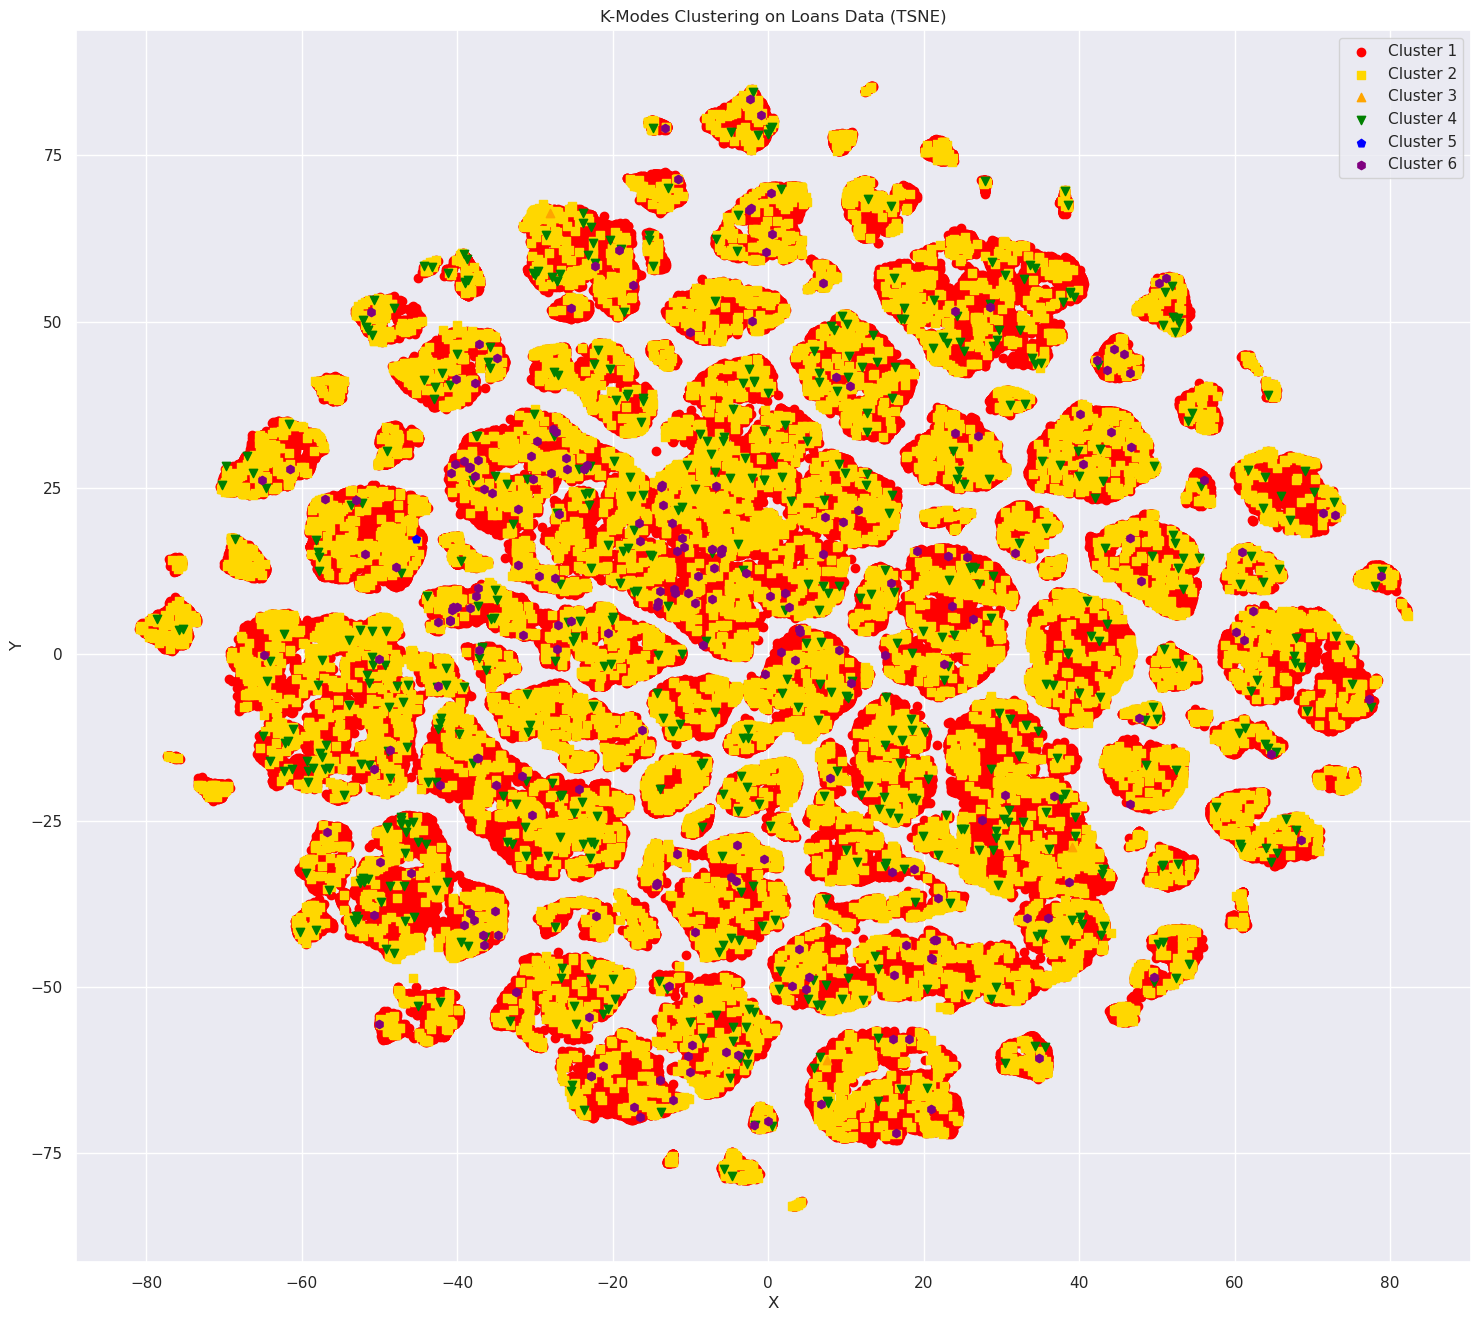

In [43]:
# Create the scatter plot
fig, ax = plt.subplots()
for c in np.unique(pcs["labels"]):
    mask = pcs["labels"] == c
    ax.scatter(
        tsne_map[:, 0][mask], tsne_map[:, 1][mask], c=colors[c], marker=markers[c]
    )

# Add axis labels and show the plot
plt.xlabel("X")
plt.ylabel("Y")
plt.title("K-Modes Clustering on Loans Data (TSNE)")
plt.legend(["Cluster" + f" {i + 1}" for i in range(18)])
plt.show();

The majority of the points belong to cluster 1 and 2. It is not clear from these visualizations that the clusters are sufficiently specified to replace the employers and job titles column. We will try the hashing vectorizer as a last resort.

## Hashing Vectorizer

In order to not increase the dimensionality significantly and risk slower down training, we will try values that are powers of 2--- 16, 32, 64, 128--- as the number of output features. Once we obtain the sparse matrix output, we will use the function below to find the number of unique rows in the sparse matrix output of the hashing vectorizer. Ideally, we do not wish to see too few unique values which may signal more hash collisions.

In [44]:
def sp_unique(sp_matrix, axis=0):
    """
    Returns a sparse matrix with the unique rows (axis=0)
    or columns (axis=1) of an input sparse matrix sp_matrix
    """
    if axis == 1:
        sp_matrix = sp_matrix.T

    old_format = sp_matrix.getformat()
    dt = np.dtype(sp_matrix)
    ncols = sp_matrix.shape[1]

    if old_format != "lil":
        sp_matrix = sp_matrix.tolil()

    _, ind = np.unique(sp_matrix.data + sp_matrix.rows, return_index=True)
    rows = sp_matrix.rows[ind]
    data = sp_matrix.data[ind]
    nrows_uniq = data.shape[0]

    sp_matrix = sp.lil_matrix((nrows_uniq, ncols), dtype=dt)
    sp_matrix.data = data
    sp_matrix.rows = rows

    ret = sp_matrix.asformat(old_format)
    if axis == 1:
        ret = ret.T
    return ret

First, obtain the list of documents:

In [45]:
docs = train["self_filled_employer_job_title"].to_list()
docs = ["missing" if doc is np.nan else doc for doc in docs]  # Impute missing values
len(docs)

338988

In [46]:
for num_feat in [2**n for n in [4, 5, 6, 7]]:
    vectorizer = HashingVectorizer(n_features=num_feat)
    X = vectorizer.fit_transform(docs)
    print(
        f"Number of output features = {num_feat} ----> Number of unique rows in the output matrix = {sp_unique(X, axis=0).shape[0]}"
    )  # Print number of unique rows

Number of output features = 16 ----> Number of unique rows in the output matrix = 24652
Number of output features = 32 ----> Number of unique rows in the output matrix = 50259
Number of output features = 64 ----> Number of unique rows in the output matrix = 73849
Number of output features = 128 ----> Number of unique rows in the output matrix = 92858


As can be seen, even if we use a 1 to 128 mapping (i.e., mapping 1 dimension to 128 dimensions), the number of potential hash collisions may still be too high for our comfort. Recall that the number of unique values in the employer and job titles feature is: 

In [47]:
len(np.unique(docs)) - 1

136808

In conclusion, we will just use the grades features to encode riskiness for this project. With more time and compute resources, I may invest time in creating a pyspark pipeline that uses embedding or other NLP techniques to extract informations for this column. 

## State 

The state column may be an important categorical feature to use to generate new features:

In [48]:
state_codes = {
    "WA": "53",
    "DE": "10",
    "DC": "11",
    "WI": "55",
    "WV": "54",
    "HI": "15",
    "FL": "12",
    "WY": "56",
    "PR": "72",
    "NJ": "34",
    "NM": "35",
    "TX": "48",
    "LA": "22",
    "NC": "37",
    "ND": "38",
    "NE": "31",
    "TN": "47",
    "NY": "36",
    "PA": "42",
    "AK": "02",
    "NV": "32",
    "NH": "33",
    "VA": "51",
    "CO": "08",
    "CA": "06",
    "AL": "01",
    "AR": "05",
    "VT": "50",
    "IL": "17",
    "GA": "13",
    "IN": "18",
    "IA": "19",
    "MA": "25",
    "AZ": "04",
    "ID": "16",
    "CT": "09",
    "ME": "23",
    "MD": "24",
    "OK": "40",
    "OH": "39",
    "UT": "49",
    "MO": "29",
    "MN": "27",
    "MI": "26",
    "RI": "44",
    "KS": "20",
    "MT": "30",
    "MS": "28",
    "SC": "45",
    "KY": "21",
    "OR": "41",
    "SD": "46",
}

### Median Interest Rates by State

In [49]:
median_interest_rates = pd.DataFrame(
    train.groupby("borrower_state")["interest_rate"].median()
).reset_index()
median_interest_rates["state_fips"] = (
    median_interest_rates["borrower_state"].str.upper().map(state_codes)
)
median_interest_rates["borrower_state"] = median_interest_rates[
    "borrower_state"
].str.upper()
median_interest_rates.head(5)

borrower_state  interest_rate state_fips
0             AK          14.09         02
1             AL          14.16         01
2             AR          14.09         05
3             AZ          13.65         04
4             CA          13.67         06

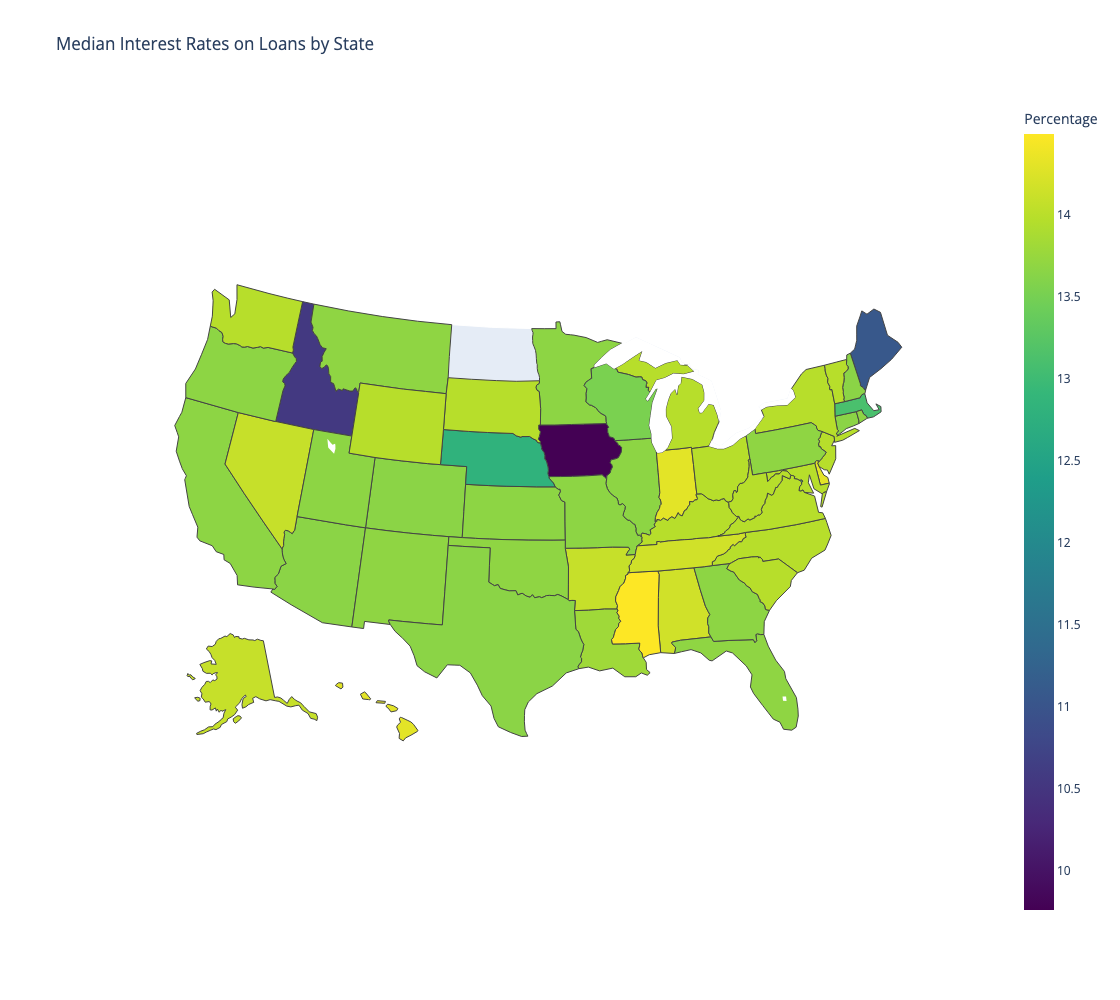

In [50]:
fig = go.Figure(
    data=go.Choropleth(
        locations=median_interest_rates["borrower_state"],
        z=median_interest_rates["interest_rate"],
        locationmode="USA-states",
        colorscale=px.colors.sequential.Viridis,
        colorbar_title="Percentage",
    )
)

fig.update_layout(
    title_text="Median Interest Rates on Loans by State",
    geo_scope="usa",
    width=1000,
    height=1000,
)

fig.show();

### Total Loan Amount Funded by State

In [51]:
sum_loan_amt = pd.DataFrame(
    train.groupby("borrower_state")["loan_amt_funded"].sum()
).reset_index()
sum_loan_amt["state_fips"] = sum_loan_amt["borrower_state"].str.upper().map(state_codes)
sum_loan_amt["borrower_state"] = sum_loan_amt["borrower_state"].str.upper()
sum_loan_amt.head(5)

borrower_state  loan_amt_funded state_fips
0             AK         15386650         02
1             AL         60058450         01
2             AR         34316650         05
3             AZ        106494875         04
4             CA        739647775         06

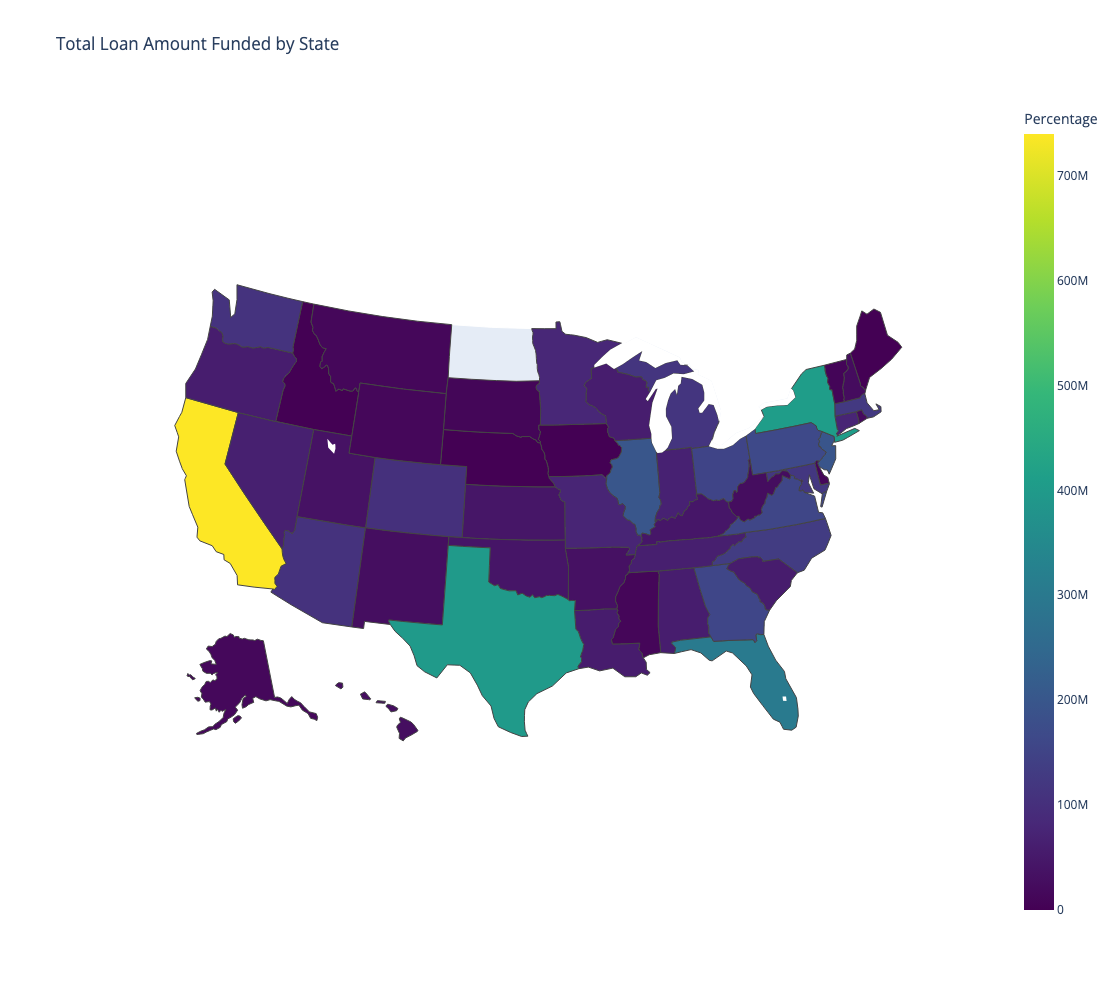

In [52]:
fig = go.Figure(
    data=go.Choropleth(
        locations=sum_loan_amt["borrower_state"],
        z=sum_loan_amt["loan_amt_funded"],
        locationmode="USA-states",
        colorscale=px.colors.sequential.Viridis,
        colorbar_title="Percentage",
    )
)

fig.update_layout(
    title_text="Total Loan Amount Funded by State",
    geo_scope="usa",
    width=1000,
    height=1000,
)

fig.show();

Interestingly, California has the largest volume of loans funded.

### Median of Applicant Income by State

In [53]:
med_income = pd.DataFrame(
    train.groupby("borrower_state")["borrower_annual_income"].median()
).reset_index()
med_income["state_fips"] = med_income["borrower_state"].str.upper().map(state_codes)
med_income["borrower_state"] = med_income["borrower_state"].str.upper()
med_income.head(5)

borrower_state  borrower_annual_income state_fips
0             AK                 68000.0         02
1             AL                 60000.0         01
2             AR                 55000.0         05
3             AZ                 60000.0         04
4             CA                 65000.0         06

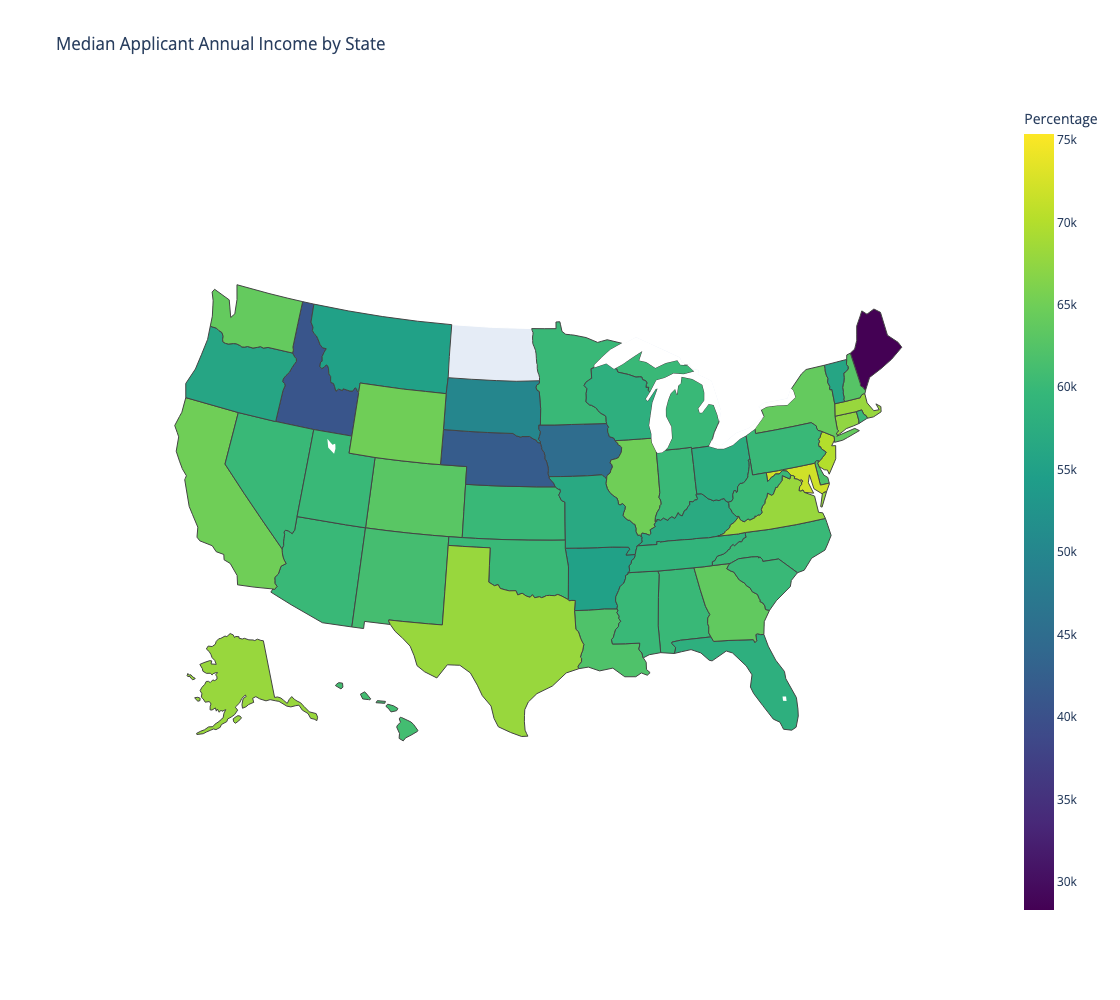

In [54]:
fig = go.Figure(
    data=go.Choropleth(
        locations=med_income["borrower_state"],
        z=med_income["borrower_annual_income"],
        locationmode="USA-states",
        colorscale=px.colors.sequential.Viridis,
        colorbar_title="Percentage",
    )
)

fig.update_layout(
    title_text="Median Applicant Annual Income by State",
    geo_scope="usa",
    width=1000,
    height=1000,
)

fig.show();

## Summary of EDA

| **Variables**                      | **Is Missing?** | **Notes**                                                                    |
|------------------------------------|-----------------|------------------------------------------------------------------------------|
|                      interest_rate |           False |                                                                       Target |
|                            id_loan |           False |                           Categorical: for each loan, generate new features  |
|                        id_borrower |           False |                        Categorical: for each borrower, generate new features |
|                 loan_amt_requested |           False |          Numerical: 1651 examples > `loan_amt_funded` otherwise all the same |
|                    loan_amt_funded |           False |       Numerical: 1651 examples < `loan_amt_requested` otherwise all the same |
|   loan_amt_investor_funded_portion |           False |                                                                    Numerical |
|              num_of_payment_months |           False |                                                                  Categorical |
|                         loan_grade |        **True** |                                                          Categorical: Impute |
|                      loan_subgrade |        **True** |                                                          Categorical: Impute |
|     self_filled_employer_job_title |        **True** |                                                          Drop and use grades |
|              num_of_years_employed |        **True** |                                                          Categorical: Impute |
|              home_ownership_status |        **True** |                                                          Categorical: Impute |
|             borrower_annual_income |        **True** |                                                          Categorical: Impute |
|            verify_income_or_source |           False |                                                                  Categorical |
|                   loan_issued_date |           False |      Categorical: Extract year and month, then use year to generate features |
|  borrower_provided_reason_for_loan |        **True** |                               Drop and use `borrower_provided_loan_category` |
|    borrower_provided_loan_category |           False |                                                                  Categorical |
|       borrower_provided_loan_title |        **True** |                               Drop and use `borrower_provided_loan_category` |
|                    zip_first_three |           False |                                                                  Categorical |
|                     borrower_state |           False |                                                                  Categorical |
|       monthly_debt_to_income_ratio |           False |                                                                    Numerical |
|                   num_of_past_dues |           False |                                                                    Numerical |
| borrower_earliest_credit_open_date |           False |      Categorical: Extract year and month, then use year to generate features |
|          num_of_creditor_inquiries |           False |                                                                    Numerical |
|    num_of_months_since_delinquency |        **True** |                                                            Numerical: Impute |
|     num_of_months_since_public_rec |        **True** |                                                                         Drop |
|            num_of_open_credit_line |           False |                                                                    Numerical |
|            num_of_derog_publib_rec |           False |                                                                    Numerical |
|           total_credit_rev_balance |           False |                                                                    Numerical |
|                 rev_line_util_rate |        **True** |                                                            Numerical: Impute |
|                  total_credit_line |           False |                                                                    Numerical |
|                   init_loan_status |           False |                                                         Categorical (Binary) |